# Linguistic Patterns: Neighborhood Evolution in Airbnb Reviews

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import csv
import geopandas as gpd
import zipfile
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from langdetect import detect, DetectorFactory, LangDetectException
from googletrans import Translator
import time
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from tqdm import tqdm

tqdm.pandas()
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

sns.set_theme()

### Data Loading

In [ ]:
review_df = pd.read_csv("data/airbnb/reviews.csv")
neighborhoods_df = pd.read_csv("data/airbnb/neighbourhoods.csv")
listing_df = pd.read_csv("data/airbnb/listings.csv")

In [92]:
reviews_full_df = pd.read_csv("data/airbnb/reviews.csv.gz", compression="gzip")
listings_full_df = pd.read_csv("data/airbnb/listings.csv.gz", compression="gzip")

In [93]:
df_census_2020 = pd.read_csv("data/census/nhgis0002_csv/nhgis0002_ds258_2020_tract.csv")
df_acs_2019_23 = pd.read_csv(
    "data/census/nhgis0002_csv/nhgis0002_ds267_20235_tract.csv"
)

In [ ]:
# Total Population
df_census_2020["total_population_2020"] = df_census_2020["U7H001"]
df_acs_2019_23["total_population"] = df_acs_2019_23["ASN1E001"]

# Median Household Income
df_acs_2019_23["median_household_income"] = df_acs_2019_23["ASQPE001"]

# Racial Composition
df_census_2020["per_white_nohisp"] = (
    df_census_2020["U7J002"] / df_census_2020["U7J001"]
) * 100
df_census_2020["per_black_aa"] = (
    df_census_2020["U7J003"] / df_census_2020["U7J001"]
) * 100
df_census_2020["per_hispanic_latino"] = (
    df_census_2020["U7L010"] / df_census_2020["U7L001"]
) * 100
df_census_2020["per_asian"] = (
    df_census_2020["U7J005"] / df_census_2020["U7J001"]
) * 100

# Education Levels
df_acs_2019_23["per_reg_high_school"] = (
    df_acs_2019_23["ASP3M017"] / df_acs_2019_23["ASP3M001"]
) * 100
df_acs_2019_23["per_ged"] = (
    df_acs_2019_23["ASP3M018"] / df_acs_2019_23["ASP3M001"]
) * 100
df_acs_2019_23["per_associates_degree"] = (
    df_acs_2019_23["ASP3M021"] / df_acs_2019_23["ASP3M001"]
) * 100
df_acs_2019_23["per_bachelors_degree"] = (
    df_acs_2019_23["ASP3M022"] / df_acs_2019_23["ASP3M001"]
) * 100
df_acs_2019_23["per_masters_degree"] = (
    df_acs_2019_23["ASP3M023"] / df_acs_2019_23["ASP3M001"]
) * 100
df_acs_2019_23["per_professional_school_degree"] = (
    df_acs_2019_23["ASP3M024"] / df_acs_2019_23["ASP3M001"]
) * 100
df_acs_2019_23["per_doctorate_degree"] = (
    df_acs_2019_23["ASP3M025"] / df_acs_2019_23["ASP3M001"]
) * 100


# Homeownership vs. Renters
df_acs_2019_23["per_owner_occupied"] = (
    df_acs_2019_23["ASS9E002"] / df_acs_2019_23["ASS9E001"]
) * 100
df_acs_2019_23["per_renter_occupied"] = (
    df_acs_2019_23["ASS9E003"] / df_acs_2019_23["ASS9E001"]
) * 100


df_census_2020["vacancy_rate"] = (
    df_census_2020["U9X003"] / df_census_2020["U9X001"]
) * 100
df_census_2020["owner_occupied"] = df_census_2020["U9X002"] - df_census_2020["U9X003"]

# Gentrification Indicators
df_acs_2019_23["median_value"] = df_acs_2019_23["ASVNE001"]
df_acs_2019_23["median_gross_rent"] = df_acs_2019_23["ASVBE001"]

In [95]:
review_df.head()

,listing_id,date
0,109,2011-08-15
1,109,2016-05-15
2,2708,2014-06-09
3,2708,2014-06-23
4,2708,2015-07-25


In [96]:
reviews_full_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,109,449036,2011-08-15,927861,Edwin,The host canceled my reservation the day befor...
1,109,74506539,2016-05-15,22509885,Jenn,Me and two friends stayed for four and a half ...
2,2708,13994902,2014-06-09,10905424,Kuberan,i had a wonderful stay. Everything from start ...
3,2708,14606598,2014-06-23,2247288,Camilla,Charles is just amazing and he made my stay sp...
4,2708,39597339,2015-07-25,27974696,Fallon,Staying with Chas was an absolute pleasure. He...


In [97]:
listings_full_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [ ]:
listings_full_df[
    [
        "neighbourhood",
        "neighbourhood_cleansed",
        "neighbourhood_group_cleansed",
        "latitude",
        "longitude",
    ]
].head()

,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude
0,NaN,Culver City,Other Cities,33.98301,-118.38607
1,Neighborhood highlights,Hollywood,City of Los Angeles,34.09741,-118.34494
2,Neighborhood highlights,Santa Monica,Other Cities,34.00467,-118.48050
3,Neighborhood highlights,Bellflower,Other Cities,33.87490,-118.11515
4,NaN,Woodland Hills,City of Los Angeles,34.16887,-118.64478


In [ ]:
listings_full_df[["neighbourhood_group_cleansed"]].value_counts()

neighbourhood_group_cleansed
City of Los Angeles             23065
Other Cities                    19146
Unincorporated Areas             4410
Name: count, dtype: int64

In [100]:
print("Number of listings: ", listings_full_df.shape)
print(
    "Number of neighbourhoods: ", listings_full_df["neighbourhood_cleansed"].nunique()
)
print(
    "Number of neighbourhood groups: ",
    listings_full_df["neighbourhood_group_cleansed"].nunique(),
)
print("Number of reviews: ", reviews_full_df.shape)

Number of listings:  (46621, 75)
Number of neighbourhoods:  266
Number of neighbourhood groups:  3
Number of reviews:  (1709336, 6)


In [101]:
neighborhoods_df.head()

,neighbourhood_group,neighbourhood
0,City of Los Angeles,Adams-Normandie
1,City of Los Angeles,Arleta
2,City of Los Angeles,Arlington Heights
3,City of Los Angeles,Atwater Village
4,City of Los Angeles,Baldwin Hills/Crenshaw


In [102]:
df_acs_2019_23.head()

,GISJOIN,YEAR,STUSAB,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,...,per_ged,per_associates_degree,per_bachelors_degree,per_masters_degree,per_professional_school_degree,per_doctorate_degree,per_owner_occupied,per_renter_occupied,median_value,median_gross_rent
0,G0600010400100,2019-2023,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,6.274510,17.254902,74.509804,49.019608,31.764706,48.627451,91.717325,8.282675,1802100,3501
1,G0600010400200,2019-2023,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,8.080808,16.161616,59.090909,56.060606,33.333333,31.818182,58.768873,41.231127,1930000,2949
2,G0600010400300,2019-2023,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,1.508621,7.974138,71.336207,82.974138,36.637931,23.922414,39.845190,60.154810,1850900,2246
3,G0600010400400,2019-2023,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,8.095238,17.857143,70.000000,37.619048,26.190476,20.238095,54.132002,45.867998,1398400,2485
4,G0600010400500,2019-2023,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,8.203125,12.304688,40.234375,33.984375,17.382812,15.820312,47.371601,52.628399,1313500,2154


In [103]:
df_census_2020.head()

,GISJOIN,YEAR,STUSAB,GEOID,GEOCODE,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,...,VAP006,VAP007,VAP008,total_population_2020,per_white_nohisp,per_black_aa,per_hispanic_latino,per_asian,vacancy_rate,owner_occupied
0,G0600010400100,2020,CA,1400000US06001400100,6001400100,4,9,California,6,Alameda County,...,48,27,8,3038,61.553654,4.739961,6.747860,17.709019,6.738351,1207
1,G0600010400200,2020,CA,1400000US06001400200,6001400200,4,9,California,6,Alameda County,...,28,16,7,2001,71.014493,1.999000,10.344828,10.344828,6.390135,778
2,G0600010400300,2020,CA,1400000US06001400300,6001400300,4,9,California,6,Alameda County,...,51,21,18,5504,62.009448,10.192587,9.938227,10.065407,6.259045,2418
3,G0600010400400,2020,CA,1400000US06001400400,6001400400,4,9,California,6,Alameda County,...,73,19,9,4112,67.242218,7.028210,9.095331,9.703307,6.639428,1698
4,G0600010400500,2020,CA,1400000US06001400500,6001400500,4,9,California,6,Alameda County,...,55,22,17,3644,53.704720,17.151482,11.992316,8.424808,4.722550,1534


In [104]:
df_census_2020["COUNTY"].value_counts()

COUNTY
Los Angeles County        2498
San Diego County           737
Orange County              614
Riverside County           518
San Bernardino County      466
Santa Clara County         408
Alameda County             379
Sacramento County          363
San Francisco County       244
Contra Costa County        242
Kern County                236
Fresno County              225
Ventura County             190
San Mateo County           174
San Joaquin County         174
Sonoma County              122
Stanislaus County          112
Santa Barbara County       109
Monterey County            104
Tulare County              103
Solano County              100
Placer County               92
Santa Cruz County           70
San Luis Obispo County      70
Marin County                63
Merced County               63
El Dorado County            55
Butte County                54
Yolo County                 53
Shasta County               50
Napa County                 40
Imperial County             40
H

In [ ]:
census_2020_cleaned = df_census_2020[
    [
        "GISJOIN",
        "COUNTY",
        "total_population_2020",
        "per_white_nohisp",
        "per_black_aa",
        "per_hispanic_latino",
        "per_asian",
        "vacancy_rate",
        "owner_occupied",
    ]
]
acs_2019_23_cleaned = df_acs_2019_23[
    [
        "GISJOIN",
        "COUNTY",
        "total_population",
        "median_household_income",
        "per_reg_high_school",
        "per_ged",
        "per_associates_degree",
        "per_bachelors_degree",
        "per_masters_degree",
        "per_professional_school_degree",
        "per_doctorate_degree",
        "per_owner_occupied",
        "per_renter_occupied",
        "median_value",
        "median_gross_rent",
    ]
]

In [106]:
census_2020_cleaned.isnull().sum()

GISJOIN                   0
COUNTY                    0
total_population_2020     0
per_white_nohisp         32
per_black_aa             32
per_hispanic_latino      32
per_asian                32
vacancy_rate             42
owner_occupied            0
dtype: int64

In [107]:
acs_2019_23_cleaned.isnull().sum()

GISJOIN                            0
COUNTY                             0
total_population                   0
median_household_income            0
per_reg_high_school                0
per_ged                            0
per_associates_degree              0
per_bachelors_degree               0
per_masters_degree                 0
per_professional_school_degree     0
per_doctorate_degree               0
per_owner_occupied                83
per_renter_occupied               83
median_value                       0
median_gross_rent                  0
dtype: int64

In [108]:
print("ACS 2019-23: ", df_acs_2019_23.shape)
print("Census 2020: ", df_census_2020.shape)

ACS 2019-23:  (9129, 505)
Census 2020:  (9129, 173)


In [ ]:
# The GeoDataFrame is discussed in the GeoPandas documentation
# https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html
listings_gdf = gpd.GeoDataFrame(
    listings_full_df,
    geometry=gpd.points_from_xy(listings_full_df.longitude, listings_full_df.latitude),
)

listings_gdf.set_crs(epsg=4326, inplace=True)

tracts_gdf_2020 = gpd.read_file(
    "data/census/nhgis0003_shape/nhgis0003_shapefile_tl2020_us_tract_2020/US_tract_2020.shp"
)

tracts_gdf_2020 = tracts_gdf_2020.to_crs(epsg=4326)

print(listings_gdf.crs)
print(tracts_gdf_2020.crs)

EPSG:4326
EPSG:4326


In [ ]:
# The sjoin function is discussed in the GeoPandas documentation
listings_with_tracts = gpd.sjoin(
    listings_gdf, tracts_gdf_2020, how="left", predicate="within"
)

In [111]:
for col in listings_with_tracts.columns:
    print(col, listings_with_tracts[col].isnull().sum())

id 0
listing_url 0
scrape_id 0
last_scraped 0
source 0
name 1
description 1136
neighborhood_overview 24035
picture_url 0
host_id 0
host_url 0
host_name 9
host_since 9
host_location 11150
host_about 21445
host_response_time 11222
host_response_rate 11222
host_acceptance_rate 9872
host_is_superhost 1642
host_thumbnail_url 9
host_picture_url 9
host_neighbourhood 10053
host_listings_count 9
host_total_listings_count 9
host_verifications 9
host_has_profile_pic 9
host_identity_verified 9
neighbourhood 24034
neighbourhood_cleansed 0
neighbourhood_group_cleansed 0
latitude 0
longitude 0
property_type 0
room_type 0
accommodates 0
bathrooms 8285
bathrooms_text 28
bedrooms 2928
beds 8394
amenities 0
price 8281
minimum_nights 0
maximum_nights 0
minimum_minimum_nights 16
maximum_minimum_nights 16
minimum_maximum_nights 16
maximum_maximum_nights 16
minimum_nights_avg_ntm 16
maximum_nights_avg_ntm 16
calendar_updated 46621
has_availability 3501
availability_30 0
availability_60 0
availability_90 0
av

In [112]:
print("Number of original listings: ", listings_full_df.shape)
print("Number of listings without tracts: ", listings_gdf.shape)
print("Number of listings: ", listings_with_tracts.shape)

Number of original listings:  (46621, 75)
Number of listings without tracts:  (46621, 76)
Number of listings:  (46621, 92)


In [113]:
listings_with_tracts.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [114]:
print("Shape of listings_with_tracts: ", listings_with_tracts.shape)
print("Shape of census_2020_cleaned: ", census_2020_cleaned.shape)
print("Shape of acs_2019_23_cleaned: ", acs_2019_23_cleaned.shape)

Shape of listings_with_tracts:  (46621, 92)
Shape of census_2020_cleaned:  (9129, 9)
Shape of acs_2019_23_cleaned:  (9129, 15)


In [ ]:
census_2020_cleaned = census_2020_cleaned[
    census_2020_cleaned["COUNTY"] == "Los Angeles County"
]
acs_2019_23_cleaned = acs_2019_23_cleaned[
    acs_2019_23_cleaned["COUNTY"] == "Los Angeles County"
]

In [ ]:
print(
    "Shape of census_2020_cleaned after filtering for Los Angeles: ",
    census_2020_cleaned.shape,
)
print(
    "Shape of acs_2019_23_cleaned after filtering for Los Angeles: ",
    acs_2019_23_cleaned.shape,
)

Shape of census_2020_cleaned after filtering for Los Angeles:  (2498, 9)
Shape of acs_2019_23_cleaned after filtering for Los Angeles:  (2498, 15)


In [117]:
listings_with_tracts = listings_with_tracts.dropna(
    subset=[
        "index_right",
        "GISJOIN",
        "STATEFP",
        "COUNTYFP",
        "TRACTCE",
        "GEOID",
        "NAME",
        "NAMELSAD",
        "MTFCC",
        "FUNCSTAT",
        "ALAND",
        "AWATER",
        "INTPTLAT",
        "INTPTLON",
        "Shape_Leng",
        "Shape_Area",
    ]
)

### Data Cleaning and Preparation

In [118]:
# Constants should be defined at the top of the file and capitalized
# as dictated by PEP 8
INVALID_VALUES = [-666666666, 100.0, 700.0, 350.0]


def clean_census_data(
    df,
    county_col,
    population_col,
    cols_to_impute,
    county_name="Los Angeles County",
    add_flag=True,
):
    """Cleans census data by filtering, replacing invalid values, and imputing missing values."""
    df = df.copy()
    df = df[df[population_col] > 0]
    df[cols_to_impute] = df[cols_to_impute].replace(INVALID_VALUES, np.nan)
    la_medians = df[df[county_col] == county_name][cols_to_impute].median(
        numeric_only=True
    )
    for col in cols_to_impute:
        df.loc[(df[county_col] == county_name) & (df[col].isnull()), col] = la_medians[
            col
        ]
    if add_flag:
        imputed_mask = df[cols_to_impute].isnull().any(axis=1)
        df["was_imputed"] = imputed_mask

    return df

In [ ]:
census_cols_to_impute = [
    "per_white_nohisp",
    "per_black_aa",
    "per_hispanic_latino",
    "per_asian",
    "vacancy_rate",
]

census_2020_cleaned = clean_census_data(
    census_2020_cleaned,
    county_col="COUNTY",
    population_col="total_population_2020",
    cols_to_impute=census_cols_to_impute,
    county_name="Los Angeles County",
)

In [ ]:
acs_cols_to_impute = [
    "median_household_income",
    "per_reg_high_school",
    "per_ged",
    "per_associates_degree",
    "per_bachelors_degree",
    "per_masters_degree",
    "per_professional_school_degree",
    "per_doctorate_degree",
    "per_owner_occupied",
    "per_renter_occupied",
    "median_value",
    "median_gross_rent",
]

acs_2019_23_cleaned = clean_census_data(
    acs_2019_23_cleaned,
    county_col="COUNTY",
    population_col="total_population",
    cols_to_impute=acs_cols_to_impute,
    county_name="Los Angeles County",
)

census_2020_cleaned = census_2020_cleaned[
    census_2020_cleaned["total_population_2020"] > 0
]

In [121]:
census_2020_cleaned.shape

(2488, 10)

In [122]:
acs_2019_23_cleaned.shape

(2477, 16)

In [123]:
print(
    "Mean per for 'per_white_nohisp', 'per_black_aa', 'per_hispanic_latino', 'per_asian', 'vacancy_rate', 'owner_occupied' in census_2020_cleaned"
)
print(
    census_2020_cleaned[
        [
            "per_white_nohisp",
            "per_black_aa",
            "per_hispanic_latino",
            "per_asian",
            "vacancy_rate",
            "owner_occupied",
        ]
    ].mean()
)

print(
    "\nMedian per for 'per_white_nohisp', 'per_black_aa', 'per_hispanic_latino', 'per_asian', 'vacancy_rate', 'owner_occupied' in census_2020_cleaned"
)
print(
    census_2020_cleaned[
        [
            "per_white_nohisp",
            "per_black_aa",
            "per_hispanic_latino",
            "per_asian",
            "vacancy_rate",
            "owner_occupied",
        ]
    ].median()
)

Mean per for 'per_white_nohisp', 'per_black_aa', 'per_hispanic_latino', 'per_asian', 'vacancy_rate', 'owner_occupied' in census_2020_cleaned
per_white_nohisp         33.277284
per_black_aa              7.939965
per_hispanic_latino      47.067654
per_asian                14.712740
vacancy_rate              4.613586
owner_occupied         1305.978698
dtype: float64

Median per for 'per_white_nohisp', 'per_black_aa', 'per_hispanic_latino', 'per_asian', 'vacancy_rate', 'owner_occupied' in census_2020_cleaned
per_white_nohisp         25.064041
per_black_aa              3.918024
per_hispanic_latino      44.869778
per_asian                 9.830991
vacancy_rate              3.607220
owner_occupied         1255.000000
dtype: float64


In [124]:
print("Null values in Census 2020:")
print(census_2020_cleaned.isnull().sum())
print("\nNull values in ACS 2019-23:")
print(acs_2019_23_cleaned.isnull().sum())

Null values in Census 2020:
GISJOIN                  0
COUNTY                   0
total_population_2020    0
per_white_nohisp         0
per_black_aa             0
per_hispanic_latino      0
per_asian                0
vacancy_rate             0
owner_occupied           0
was_imputed              0
dtype: int64

Null values in ACS 2019-23:
GISJOIN                           0
COUNTY                            0
total_population                  0
median_household_income           0
per_reg_high_school               0
per_ged                           0
per_associates_degree             0
per_bachelors_degree              0
per_masters_degree                0
per_professional_school_degree    0
per_doctorate_degree              0
per_owner_occupied                0
per_renter_occupied               0
median_value                      0
median_gross_rent                 0
was_imputed                       0
dtype: int64


In [125]:
print("Shape of listings_with_tracts: ", listings_with_tracts.shape)
print("Shape of census_2020_cleaned: ", census_2020_cleaned.shape)
print("Shape of acs_2019_23_cleaned: ", acs_2019_23_cleaned.shape)

Shape of listings_with_tracts:  (46560, 92)
Shape of census_2020_cleaned:  (2488, 10)
Shape of acs_2019_23_cleaned:  (2477, 16)


In [ ]:
print("Shape of listings_with_tracts: ", listings_with_tracts.shape)

print("Difference in columns between census_2020_cleaned and listings_with_tracts: ")
print(len(set(census_2020_cleaned.columns) - set(listings_with_tracts.columns)))
listings_with_census_2020_data = listings_with_tracts.merge(
    census_2020_cleaned, how="left", left_on="GISJOIN", right_on="GISJOIN"
)

listings_with_census_acs_data = listings_with_census_2020_data.merge(
    acs_2019_23_cleaned,
    how="left",
    left_on=["GISJOIN", "COUNTY"],
    right_on=["GISJOIN", "COUNTY"],
)

listings_with_census_acs_data.rename(
    columns={"was_imputed_x": "was_imputed_census", "was_imputed_y": "was_imputed_acs"},
    inplace=True,
)


print(
    "\nNumber of listings with census 2020 data: ", listings_with_census_2020_data.shape
)
print("Number of listings with ACS 2019-23 data: ", listings_with_census_acs_data.shape)

print(
    "\nDifference in columns between listings_with_census_2020_data and listings_with_census_acs_data: "
)
print(
    len(
        set(listings_with_census_acs_data.columns)
        - set(listings_with_census_2020_data.columns)
    )
)

Shape of listings_with_tracts:  (46560, 92)
Difference in columns between census_2020_cleaned and listings_with_tracts: 
9

Number of listings with census 2020 data:  (46560, 101)
Number of listings with ACS 2019-23 data:  (46560, 115)

Difference in columns between listings_with_census_2020_data and listings_with_census_acs_data: 
15


In [127]:
listings_with_census_acs_data.isnull().sum()
for col in listings_with_census_acs_data.columns:
    if listings_with_census_acs_data[col].isnull().sum() > 0:
        print(f"{col}: {listings_with_census_acs_data[col].isnull().sum()}")

name: 1
description: 1135
neighborhood_overview: 24008
host_name: 9
host_since: 9
host_location: 11126
host_about: 21410
host_response_time: 11217
host_response_rate: 11217
host_acceptance_rate: 9867
host_is_superhost: 1640
host_thumbnail_url: 9
host_picture_url: 9
host_neighbourhood: 10037
host_listings_count: 9
host_total_listings_count: 9
host_verifications: 9
host_has_profile_pic: 9
host_identity_verified: 9
neighbourhood: 24007
bathrooms: 8276
bathrooms_text: 28
bedrooms: 2927
beds: 8385
price: 8272
minimum_minimum_nights: 16
maximum_minimum_nights: 16
minimum_maximum_nights: 16
maximum_maximum_nights: 16
minimum_nights_avg_ntm: 16
maximum_nights_avg_ntm: 16
calendar_updated: 46560
has_availability: 3499
first_review: 12748
last_review: 12748
review_scores_rating: 12748
review_scores_accuracy: 12756
review_scores_cleanliness: 12757
review_scores_checkin: 12763
review_scores_communication: 12757
review_scores_location: 12764
review_scores_value: 12766
license: 33320
reviews_per_mon

In [ ]:
print("GISJOINs in listings_with_tracts:", listings_with_tracts["GISJOIN"].nunique())
print("GISJOINs in census_2020_cleaned:", census_2020_cleaned["GISJOIN"].nunique())
print("GISJOINs in acs_2019_23_cleaned:", acs_2019_23_cleaned["GISJOIN"].nunique())


GISJOINs in listings_with_tracts: 2340
GISJOINs in census_2020_cleaned: 2488
GISJOINs in acs_2019_23_cleaned: 2477


In [ ]:
unmatched_census = listings_with_tracts[
    ~listings_with_tracts["GISJOIN"].isin(census_2020_cleaned["GISJOIN"])
]
print(f"Listings not matched to census: {unmatched_census.shape[0]}")

unmatched_acs = listings_with_census_2020_data[
    ~listings_with_census_2020_data[["GISJOIN", "COUNTY"]]
    .apply(tuple, axis=1)
    .isin(acs_2019_23_cleaned[["GISJOIN", "COUNTY"]].apply(tuple, axis=1))
]
print(f"Listings not matched to ACS: {unmatched_acs.shape[0]}")


Listings not matched to census: 80
Listings not matched to ACS: 173


In [ ]:
census_acs_cols = [
    "total_population_2020",
    "per_white_nohisp",
    "per_black_aa",
    "per_hispanic_latino",
    "per_asian",
    "vacancy_rate",
    "owner_occupied",
    "was_imputed_census",
    "total_population",
    "median_household_income",
    "per_reg_high_school",
    "per_ged",
    "per_associates_degree",
    "per_bachelors_degree",
    "per_masters_degree",
    "per_professional_school_degree",
    "per_doctorate_degree",
    "per_owner_occupied",
    "per_renter_occupied",
    "median_value",
    "median_gross_rent",
    "was_imputed_acs",
]

listings_with_census_acs_data["missing_socio_data"] = (
    listings_with_census_acs_data[census_acs_cols].isnull().any(axis=1)
)


In [ ]:
listings_with_census_acs_data["missing_socio_data"].value_counts()

missing_socio_data
False    46387
True       173
Name: count, dtype: int64

In [ ]:
print(
    "\nNumber of listing with missing GISJOIN: ",
    listings_with_tracts[listings_with_tracts["GISJOIN"].isnull()].shape,
)
print(
    "Number of listing (with census data) missing GISJOIN: ",
    listings_with_census_2020_data[
        listings_with_census_2020_data["GISJOIN"].isnull()
    ].shape,
)
print(
    "Number of listing (with ACS data) missing GISJOIN: ",
    listings_with_census_acs_data[
        listings_with_census_acs_data["GISJOIN"].isnull()
    ].shape,
)


missing_gisjoin = set(listings_with_tracts["GISJOIN"]) - set(
    census_2020_cleaned["GISJOIN"]
)
print(
    "Number of GISJOINs in listings_with_tracts but not in census_2020_cleaned: ",
    len(missing_gisjoin),
)
print(
    "GISJOINs in listings_with_tracts but not in census_2020_cleaned: ", missing_gisjoin
)

missing_gisjoin_acs = set(listings_with_census_2020_data["GISJOIN"]) - set(
    acs_2019_23_cleaned["GISJOIN"]
)
print(
    "Number of GISJOINs in listings_with_census_2020_data but not in acs_2019_23_cleaned: ",
    len(missing_gisjoin_acs),
)



Number of listing with missing GISJOIN:  (0, 92)
Number of listing (with census data) missing GISJOIN:  (0, 101)
Number of listing (with ACS data) missing GISJOIN:  (0, 116)
Number of GISJOINs in listings_with_tracts but not in census_2020_cleaned:  2
GISJOINs in listings_with_tracts but not in census_2020_cleaned:  {'G0600370980030', 'G0600370980039'}
Number of GISJOINs in listings_with_census_2020_data but not in acs_2019_23_cleaned:  10


In [ ]:
no_match = listings_with_tracts[listings_with_tracts["GISJOIN"].isnull()]
print(no_match.shape)

has_match_missing_demo = listings_with_census_2020_data[
    (listings_with_census_2020_data["GISJOIN"].notnull())
    & (listings_with_census_2020_data["per_white_nohisp"].isnull())
]
print(has_match_missing_demo.shape)


(0, 92)
(80, 101)


In [ ]:
print("2020 Census data shape: ", df_census_2020.shape)


print("Listings full DataFrame shape: ", listings_full_df.shape)


print("Listings with tracts shape: ", listings_with_tracts.shape)


print("Merged DataFrame shape: ", listings_with_census_acs_data.shape)

print("2019-23 ACS data shape: ", df_acs_2019_23.shape)

2020 Census data shape:  (9129, 173)
Listings full DataFrame shape:  (46621, 75)
Listings with tracts shape:  (46560, 92)
Merged DataFrame shape:  (46560, 116)
2019-23 ACS data shape:  (9129, 505)


In [ ]:
la_df = reviews_full_df.merge(
    listings_with_census_acs_data, how="left", left_on="listing_id", right_on="id"
)


In [ ]:
cols_to_drop = [
    "id_y",
    "listing_url",
    "scrape_id",
    "last_scraped",
    "source",
    "description",
    "neighborhood_overview",
    "picture_url",
    "host_id",
    "host_url",
    "host_name",
    "host_since",
    "host_location",
    "host_about",
    "host_response_time",
    "host_response_rate",
    "host_acceptance_rate",
    "host_is_superhost",
    "host_thumbnail_url",
    "host_picture_url",
    "host_neighbourhood",
    "host_listings_count",
    "host_total_listings_count",
    "host_verifications",
    "host_has_profile_pic",
    "host_identity_verified",
    "neighbourhood",
    "calendar_updated",
    "calendar_last_scraped",
    "availability_90",
    "availability_365",
    "instant_bookable",
    "calculated_host_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms",
]

la_df_cleaned = la_df.drop(columns=cols_to_drop)
la_df_cleaned = la_df_cleaned.rename(
    columns={"total_population": "total_population_2019_23"}
)

In [ ]:
la_df_cleaned.to_csv("data/airbnb/la_reviews_with_socioeconomic_data.csv", index=False)

In [141]:
print("Review data shape: ", reviews_full_df.shape)
print("Listings with census data shape: ", listings_with_census_acs_data.shape)
print("Merged DataFrame shape: ", la_df.shape)
print("Merged Cleaned DataFrame shape: ", la_df_cleaned.shape)

Review data shape:  (1709336, 6)
Listings with census data shape:  (46560, 116)
Merged DataFrame shape:  (1709336, 122)
Merged Cleaned DataFrame shape:  (1709336, 86)


In [ ]:
start_date = "2020-01-01"
end_date = "2024-31-12"

filtered_la_df = la_df_cleaned[
    (la_df_cleaned["date"] >= start_date) & (la_df_cleaned["date"] <= end_date)
].copy()

In [ ]:
filtered_la_df.dropna(
    subset=["GISJOIN", "total_population_2019_23", "total_population_2020"],
    inplace=True,
)

In [158]:
for col in filtered_la_df.columns:
    print(col, filtered_la_df[col].isnull().sum())

listing_id 0
id_x 0
date 0
reviewer_id 0
reviewer_name 0
comments 317
name 0
neighbourhood_cleansed 0
neighbourhood_group_cleansed 0
latitude 0
longitude 0
property_type 0
room_type 0
accommodates 0
bathrooms 60008
bathrooms_text 161
bedrooms 17504
beds 60955
amenities 0
price 59932
minimum_nights 0
maximum_nights 0
minimum_minimum_nights 6
maximum_minimum_nights 6
minimum_maximum_nights 6
maximum_maximum_nights 6
minimum_nights_avg_ntm 6
maximum_nights_avg_ntm 6
has_availability 3486
availability_30 0
availability_60 0
number_of_reviews 0
number_of_reviews_ltm 0
number_of_reviews_l30d 0
first_review 0
last_review 0
review_scores_rating 0
review_scores_accuracy 12
review_scores_cleanliness 13
review_scores_checkin 12
review_scores_communication 12
review_scores_location 12
review_scores_value 13
license 643469
reviews_per_month 0
geometry 0
index_right 0
GISJOIN 0
STATEFP 0
COUNTYFP 0
TRACTCE 0
GEOID 0
NAME 0
NAMELSAD 0
MTFCC 0
FUNCSTAT 0
ALAND 0
AWATER 0
INTPTLAT 0
INTPTLON 0
Shape_Le

In [159]:
print("Filtered DataFrame shape: ", filtered_la_df.shape)

Filtered DataFrame shape:  (1187931, 86)


### Text Processing and Sentiment Analysis

In [ ]:
DetectorFactory.seed = 0


def detect_language(text):
    try:
        return detect(str(text))
    except:
        return "unknown"


filtered_la_df["lang"] = filtered_la_df["comments"].progress_apply(detect_language)

100%|██████████| 1187931/1187931 [29:47<00:00, 664.62it/s] 


In [ ]:
filtered_la_df["lang"].value_counts()

lang
en         1093619
es           21514
fr           14278
de            9858
zh-cn         7045
ro            6574
ko            5032
unknown       3286
pt            3143
so            2414
af            2272
it            2266
ja            2022
tl            1901
nl            1414
ca            1327
cs            1085
pl             992
zh-tw          815
ru             759
no             746
hr             603
sw             569
da             546
cy             499
hu             453
sv             438
tr             383
id             333
vi             268
sl             259
et             225
sk             216
he             213
fi             200
ar             164
lt              37
bg              30
sq              28
uk              28
lv              26
th              21
el              16
mk               8
ur               4
fa               2
Name: count, dtype: int64

In [ ]:
filtered_la_df["lang"].value_counts(normalize=True)

lang
en         0.920608
es         0.018110
fr         0.012019
de         0.008298
zh-cn      0.005930
ro         0.005534
ko         0.004236
unknown    0.002766
pt         0.002646
so         0.002032
af         0.001913
it         0.001908
ja         0.001702
tl         0.001600
nl         0.001190
ca         0.001117
cs         0.000913
pl         0.000835
zh-tw      0.000686
ru         0.000639
no         0.000628
hr         0.000508
sw         0.000479
da         0.000460
cy         0.000420
hu         0.000381
sv         0.000369
tr         0.000322
id         0.000280
vi         0.000226
sl         0.000218
et         0.000189
sk         0.000182
he         0.000179
fi         0.000168
ar         0.000138
lt         0.000031
bg         0.000025
sq         0.000024
uk         0.000024
lv         0.000022
th         0.000018
el         0.000013
mk         0.000007
ur         0.000003
fa         0.000002
Name: proportion, dtype: float64

In [ ]:
filtered_la_df[filtered_la_df["lang"] == "unknown"][["comments", "lang"]].sample(10)

,comments,lang
436175,.,unknown
247071,10/10,unknown
526703,👍🏻👍🏻👍🏻,unknown
825184,🥳🥳🥳,unknown
468066,.,unknown
130926,👍🏽,unknown
1131811,💡,unknown
850970,😍,unknown
469128,🌟 🌟🌟🌟🌟,unknown
189583,.,unknown


In [ ]:
filtered_la_df[["lang", "comments"]].sample(25)

,lang,comments
63153,en,second time staying here and still loving it. ...
15473,en,If you are looking for a place to unwind and t...
907276,en,Incredible property! So well appointed in a m...
11095,en,Place just as advertised and host is absolutel...
532563,en,If you need to stay in WeHo- stay here at Eva’...
838882,en,The host was able to accommodate me in my last...
717375,en,Very comfortable and modern!
555941,en,Simon provided thorough details regarding find...
668473,en,We loved our stay! Our only wish was that we h...
1176160,ko,따듯했고.안전하고 친절한 호스트 <br/>집도 이뻣다.위치도 바다랑 가까워서 좋았다.


In [ ]:
filtered_la_df = filtered_la_df[filtered_la_df["lang"] == "en"].copy()
filtered_la_df["lang"].value_counts()

lang
en    1093619
Name: count, dtype: int64

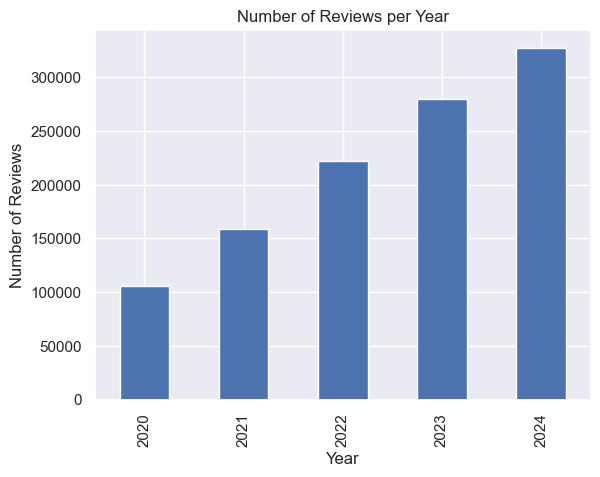

In [664]:
filtered_la_df["date"] = pd.to_datetime(filtered_la_df["date"])
filtered_la_df["date"].dt.year.value_counts().sort_index().plot(kind="bar")
plt.title("Number of Reviews per Year")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.show()

In [665]:
filtered_la_df["date"].dt.year.value_counts()

date
2024    327593
2023    279635
2022    221789
2021    158668
2020    105897
Name: count, dtype: int64

In [ ]:
def vader_clean_text(text):
    text = str(text).strip()
    # Regex documentation and ChaGPT was use to create and improve the following regex lines
    text = re.sub(r"<br\s*/?>", " ", text)
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"\s+", " ", text)
    return text


filtered_la_df["vader_comments"] = filtered_la_df["comments"].astype(str)
filtered_la_df["vader_comments"].isnull().sum()
filtered_la_df["vader_comments"] = filtered_la_df["comments"].apply(vader_clean_text)
filtered_la_df["vader_comments"].isnull().sum()

np.int64(0)

In [ ]:
filtered_la_df[["lang", "vader_comments"]].sample(25)

,lang,vader_comments
669246,en,Really love the stay and it’s just few minutes...
727218,en,Great stay!
484366,en,Convenient location with Vons next door and wa...
1002745,en,We enjoyed our stay! Thank you so much for
543760,en,"Kim is an excellent host, very kind and very g..."
924796,en,"Patrick's place was great, very private and qu..."
963600,en,A beautiful place in the hills of Topanga. The...
848449,en,Excellent location in Santa Monica. Good views...
761608,en,Such a wonderful home for our family. We went ...
68726,en,"Great place, awesome location for access to lo..."


In [ ]:
# Consulted the Vader documentation to understand the polarity_scores and SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
filtered_la_df["sentiment_score"] = filtered_la_df["vader_comments"].progress_apply(
    lambda x: analyzer.polarity_scores(x)["compound"]
)

  0%|          | 0/1093619 [00:00<?, ?it/s]

100%|██████████| 1093619/1093619 [02:52<00:00, 6335.87it/s]


In [ ]:
filtered_la_df[filtered_la_df["sentiment_score"] < 0.5][
    ["vader_comments", "sentiment_score", "review_scores_rating"]
].sort_values(by="sentiment_score", ascending=True).head(20)

,vader_comments,sentiment_score,review_scores_rating
180782,DO NOT RENT. I've been using Airbnb as both a ...,-0.9972,4.68
608002,This was the worst Air BnB stay I’ve ever had....,-0.9972,4.16
325127,This is a converted garage with some major dus...,-0.9972,4.86
235338,Unfortunately this was a nightmare of an Air B...,-0.9972,4.47
630040,Buyer beware. This apartment does not match th...,-0.9958,4.34
1088625,Horrific Stay with Roaches - Avoid at All Cost...,-0.9956,4.53
482004,DO NOT STAY HERE. THE BEDROOM HAS BED BUGS. Af...,-0.9956,4.70
33720,I'll start by saying I love AirbNb and nearly ...,-0.9954,4.38
551899,Warning! Do NOT book. This was easily my worst...,-0.9951,4.39
387249,Unfortunately one of the worst Airbnb in my li...,-0.9948,4.64


In [ ]:
filtered_la_df[filtered_la_df["review_scores_rating"] < 3][
    ["vader_comments", "sentiment_score", "review_scores_rating"]
].sort_values(by="sentiment_score", ascending=True).head(20)

,vader_comments,sentiment_score,review_scores_rating
1037256,"Hello, the owner is not bad as a person and he...",-0.9917,1.00
1182966,Arrival was a disaster.. layout of unit and pi...,-0.9911,1.00
838484,It was not bad at first until check out they t...,-0.9894,2.00
442008,"WARNING: unsafe air quality in this unit, and ...",-0.9893,1.00
415845,Don't believe the ad photos. Maybe everything ...,-0.9885,2.50
1169778,Benjamin made the stay terrible due to his lie...,-0.9875,2.33
665632,We weren’t able to wash our clothes at the air...,-0.9854,1.00
1185013,I reserved this home for two days. But unfortu...,-0.9848,1.00
1169779,Airbnb should not allow this host to list any ...,-0.9833,2.33
874000,"This Renter is a LIAR , RUDE and INCONSIDERATE...",-0.9804,1.00


In [ ]:
filtered_la_df["review_scores_rating"].value_counts()

review_scores_rating
5.00    70700
4.94    54121
4.93    51974
4.96    49292
4.95    47435
        ...  
3.17        6
3.13        5
2.25        4
1.25        4
1.50        2
Name: count, Length: 141, dtype: int64

In [ ]:
filtered_la_df["normalized_rating"] = filtered_la_df["review_scores_rating"] / 5
filtered_la_df["rating_sentiment_gap"] = (
    filtered_la_df["normalized_rating"] - filtered_la_df["sentiment_score"]
)

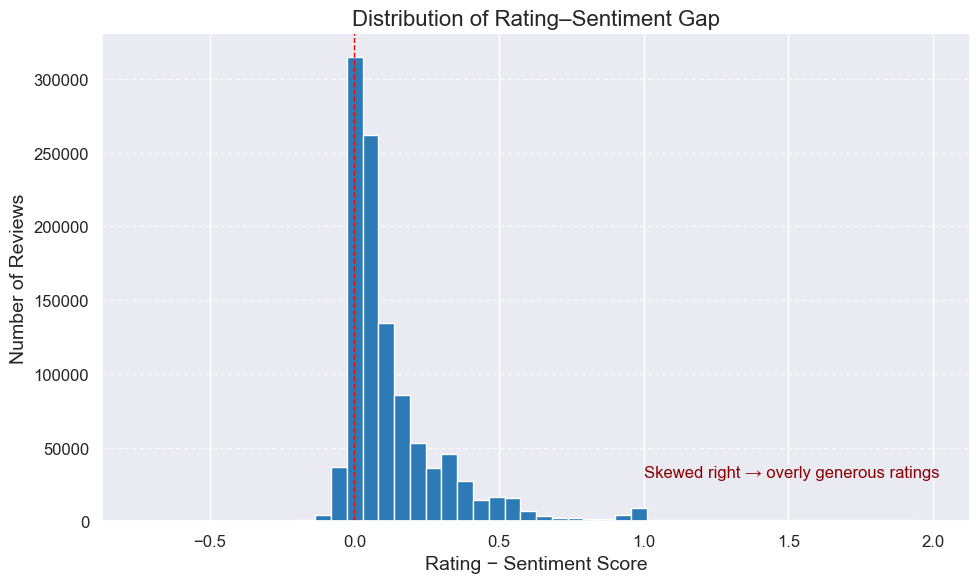

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(
    filtered_la_df["rating_sentiment_gap"], bins=50, color="#2C7BB6", edgecolor="white"
)
plt.title("Distribution of Rating–Sentiment Gap", fontsize=16)
plt.xlabel("Rating − Sentiment Score", fontsize=14)
plt.ylabel("Number of Reviews", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.axvline(0, color="red", linestyle="--", linewidth=1)
plt.text(
    1.0, 30000, "Skewed right → overly generous ratings", fontsize=12, color="darkred"
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [670]:
print("Mean rating_sentiment_gap: ", filtered_la_df["rating_sentiment_gap"].mean())
print("Median rating_sentiment_gap: ", filtered_la_df["rating_sentiment_gap"].median())

Mean rating_sentiment_gap:  0.1436846967122721
Median rating_sentiment_gap:  0.0630999999999999


In [ ]:
tract_level_summary = (
    filtered_la_df.groupby("GISJOIN")
    .agg(
        {
            "sentiment_score": "mean",
            "normalized_rating": "mean",
            "rating_sentiment_gap": "mean",
            "id_x": "count",
            "median_household_income": "first",
            "per_white_nohisp": "first",
            "per_black_aa": "first",
            "per_hispanic_latino": "first",
            "per_asian": "first",
            "vacancy_rate": "first",
            "owner_occupied": "first",
            "median_value": "first",
            "median_gross_rent": "first",
            "per_reg_high_school": "first",
            "per_ged": "first",
            "per_associates_degree": "first",
            "per_bachelors_degree": "first",
            "per_masters_degree": "first",
            "per_professional_school_degree": "first",
            "per_doctorate_degree": "first",
            "per_owner_occupied": "first",
            "per_renter_occupied": "first",
            "median_value": "first",
            "median_gross_rent": "first",
        }
    )
    .reset_index()
    .rename(columns={"id_x": "review_count"})
)

In [420]:
tract_level_summary

,GISJOIN,sentiment_score,normalized_rating,rating_sentiment_gap,review_count,median_household_income,per_white_nohisp,per_black_aa,per_hispanic_latino,per_asian,...,median_gross_rent,per_reg_high_school,per_ged,per_associates_degree,per_bachelors_degree,per_masters_degree,per_professional_school_degree,per_doctorate_degree,per_owner_occupied,per_renter_occupied
0,G0600370101110,0.874675,1.000000,0.125325,12,84091.0,62.220869,1.502233,28.034917,8.932197,...,1720.0,75.378788,12.121212,51.893939,72.727273,31.439394,10.606061,5.303030,51.219512,48.780488
1,G0600370101122,0.833120,1.000000,0.166880,15,99583.0,73.041845,0.831545,14.538627,10.836910,...,3479.0,22.126437,5.890805,18.390805,25.862069,17.672414,8.764368,11.925287,77.896233,22.103767
2,G0600370101220,0.777200,1.000000,0.222800,1,69676.0,56.848086,1.255981,32.326555,10.705742,...,1441.0,50.692521,8.864266,20.775623,60.664820,21.606648,15.235457,9.695291,43.920413,56.079587
3,G0600370101221,0.871620,0.980000,0.108380,10,53798.0,58.333333,2.526132,34.204413,7.200929,...,1761.0,33.208255,21.013133,22.514071,32.082552,23.452158,4.315197,10.694184,22.184761,77.815239
4,G0600370101222,0.896975,0.950000,0.053025,4,45662.0,55.235043,3.347578,37.037037,5.270655,...,1817.0,69.520548,25.342466,44.520548,50.000000,33.219178,7.876712,4.794521,7.911392,92.088608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2223,G0600370980023,0.746411,0.909194,0.162782,124,86850.0,42.105263,0.000000,36.842105,0.000000,...,1884.0,32.558140,32.558140,32.558140,48.837209,32.558140,48.837209,32.558140,45.458937,0.000000
2224,G0600370980024,0.873763,0.976699,0.102937,123,125625.0,65.929204,11.061947,12.389381,10.176991,...,1884.0,91.044776,20.895522,20.895522,40.298507,26.865672,20.895522,20.895522,61.250000,38.750000
2225,G0600370980031,0.862972,0.998000,0.135028,209,86850.0,75.457666,14.931350,40.560641,5.263158,...,1884.0,104.347826,86.956522,69.565217,41.304348,15.217391,30.434783,34.782609,42.857143,57.142857
2226,G0600370980035,0.713532,0.951390,0.237858,118,65750.0,21.348315,0.802568,80.256822,7.383628,...,1482.0,41.830065,9.150327,3.921569,9.803922,19.607843,9.150327,9.150327,51.851852,48.148148


In [ ]:
filtered_la_df["GISJOIN"].nunique()

2228

In [422]:
tract_level_summary.isnull().sum()

GISJOIN                           0
sentiment_score                   0
normalized_rating                 0
rating_sentiment_gap              0
review_count                      0
median_household_income           0
per_white_nohisp                  0
per_black_aa                      0
per_hispanic_latino               0
per_asian                         0
vacancy_rate                      0
owner_occupied                    0
median_value                      0
median_gross_rent                 0
per_reg_high_school               0
per_ged                           0
per_associates_degree             0
per_bachelors_degree              0
per_masters_degree                0
per_professional_school_degree    0
per_doctorate_degree              0
per_owner_occupied                0
per_renter_occupied               0
dtype: int64

In [ ]:
def classify_sentiment_gap(row):
    """Classify the sentiment gap based on sentiment score and normalized rating."""
    if row["sentiment_score"] < -0.2 and row["normalized_rating"] > 0.8:
        return "Negative Text, High Rating"
    elif row["sentiment_score"] > 0.5 and row["normalized_rating"] < 0.6:
        return "Positive Text, Low Rating"
    else:
        return "Aligned"


filtered_la_df["mismatch_label"] = filtered_la_df.progress_apply(
    classify_sentiment_gap, axis=1
)


100%|██████████| 1093619/1093619 [00:12<00:00, 84262.90it/s] 


In [ ]:
filtered_la_df["mismatch_label"].value_counts()

mismatch_label
Aligned                       1081404
Negative Text, High Rating      12146
Positive Text, Low Rating          69
Name: count, dtype: int64

In [ ]:
tract_mismatch_counts = (
    filtered_la_df.groupby(["GISJOIN", "mismatch_label"]).size().unstack(fill_value=0)
)

tract_mismatch_counts["total_reviews"] = tract_mismatch_counts.sum(axis=1)

tract_mismatch_counts["pct_negative_text_high_rating"] = (
    tract_mismatch_counts.get("Negative Text, High Rating", 0)
    / tract_mismatch_counts["total_reviews"]
)

tract_mismatch_counts["pct_positive_text_low_rating"] = (
    tract_mismatch_counts.get("Positive Text, Low Rating", 0)
    / tract_mismatch_counts["total_reviews"]
)

tract_mismatch_counts = tract_mismatch_counts.reset_index()

tract_mismatch_counts


mismatch_label,GISJOIN,Aligned,"Negative Text, High Rating","Positive Text, Low Rating",total_reviews,pct_negative_text_high_rating,pct_positive_text_low_rating
0,G0600370101110,12,0,0,12,0.000000,0.0
1,G0600370101122,14,1,0,15,0.066667,0.0
2,G0600370101220,1,0,0,1,0.000000,0.0
3,G0600370101221,10,0,0,10,0.000000,0.0
4,G0600370101222,4,0,0,4,0.000000,0.0
...,...,...,...,...,...,...,...
2223,G0600370980023,117,7,0,124,0.056452,0.0
2224,G0600370980024,123,0,0,123,0.000000,0.0
2225,G0600370980031,209,0,0,209,0.000000,0.0
2226,G0600370980035,114,4,0,118,0.033898,0.0


In [ ]:
def tfidf_clean_text(text):
    text = str(text).lower()
    # Regex documentation and ChatGPT was use to create and improve the following regex lines
    text = re.sub(r"<br\s*/?>", " ", text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    # The list comprehension method is explained in the W3Schools Python documentation
    tokens = [word for word in tokens if word not in stopwords.words("english")]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

In [ ]:
mismatch_reviews = filtered_la_df[
    filtered_la_df["mismatch_label"].isin(
        ["Negative Text, High Rating", "Positive Text, Low Rating"]
    )
].copy()
mismatch_reviews["comments_clean_tfidf"] = mismatch_reviews["comments"].progress_apply(
    tfidf_clean_text
)

100%|██████████| 12215/12215 [00:59<00:00, 204.69it/s]


In [ ]:
grouped = mismatch_reviews.groupby("mismatch_label")

# Referred to the Scikit-learn and GeeksforGeeks documentation for TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

top_words = {}

for label, group in grouped:
    tfidf_matrix = vectorizer.fit_transform(group["comments_clean_tfidf"])
    # Referred to the Numpy documentation for the A1 method
    tfidf_scores = tfidf_matrix.sum(axis=0).A1
    vocab = vectorizer.get_feature_names_out()
    # W3Schools documentation was used to understand the zip function and
    # ChatGPT was used to format the code
    top_terms = sorted(zip(vocab, tfidf_scores), key=lambda x: x[1], reverse=True)[:20]
    top_words[label] = top_terms


In [429]:
for label, terms in top_words.items():
    print(f"\nTop terms for {label}:")
    for term, score in terms:
        print(f"{term}: {score:.3f}")


Top terms for Negative Text, High Rating:
place: 563.311
stay: 461.045
host: 423.139
room: 394.667
house: 375.603
night: 300.497
dirty: 298.305
bed: 292.797
would: 290.197
parking: 287.350
one: 279.151
location: 275.533
bathroom: 273.889
day: 261.402
clean: 259.652
airbnb: 255.681
didnt: 253.470
time: 251.302
issue: 242.514
get: 239.871

Top terms for Positive Text, Low Rating:
great: 4.219
good: 3.233
location: 3.193
place: 3.091
stay: 3.027
host: 2.746
room: 2.013
would: 1.890
house: 1.881
property: 1.838
nice: 1.776
airbnb: 1.766
need: 1.719
like: 1.625
people: 1.623
area: 1.598
even: 1.570
clean: 1.519
night: 1.517
great location: 1.496


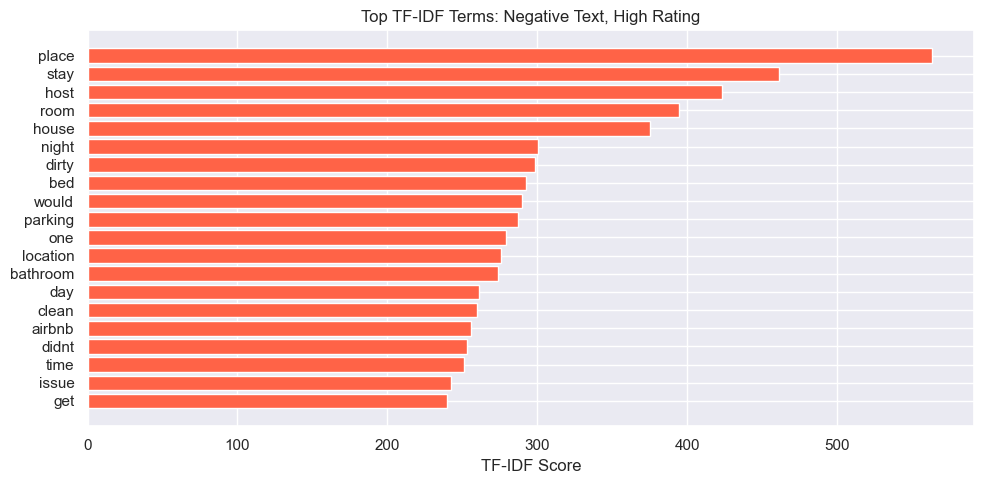

In [ ]:
label = "Negative Text, High Rating"
# The zip function is discussed in the W3Schools documentation
# Consulted GeeksforGeeks for the * operator to unpack the list
terms, scores = zip(*top_words[label])

plt.figure(figsize=(10, 5))
# Consulted for GeeksforGeeks for the barh function
plt.barh(terms[::-1], scores[::-1], color="tomato")
plt.title(f"Top TF-IDF Terms: {label}")
plt.xlabel("TF-IDF Score")
plt.tight_layout()
plt.show()


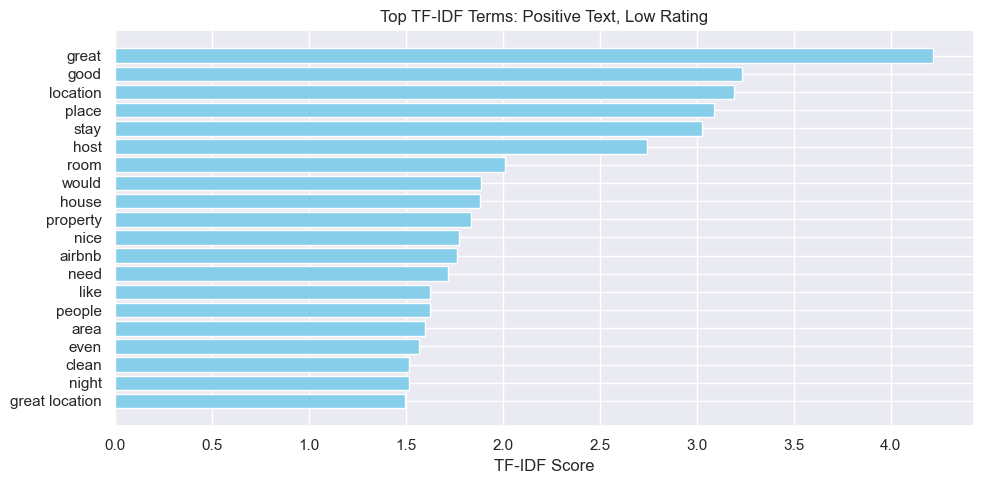

In [ ]:
label = "Positive Text, Low Rating"
# The zip function is discussed in the W3Schools documentation
# Consulted GeeksforGeeks for the * operator to unpack the list
terms, scores = zip(*top_words[label])

plt.figure(figsize=(10, 5))
# Consulted for GeeksforGeeks for the barh function
plt.barh(terms[::-1], scores[::-1], color="skyblue")
plt.title(f"Top TF-IDF Terms: {label}")
plt.xlabel("TF-IDF Score")
plt.tight_layout()
plt.show()

### Exploratory Data Analysis (EDA)

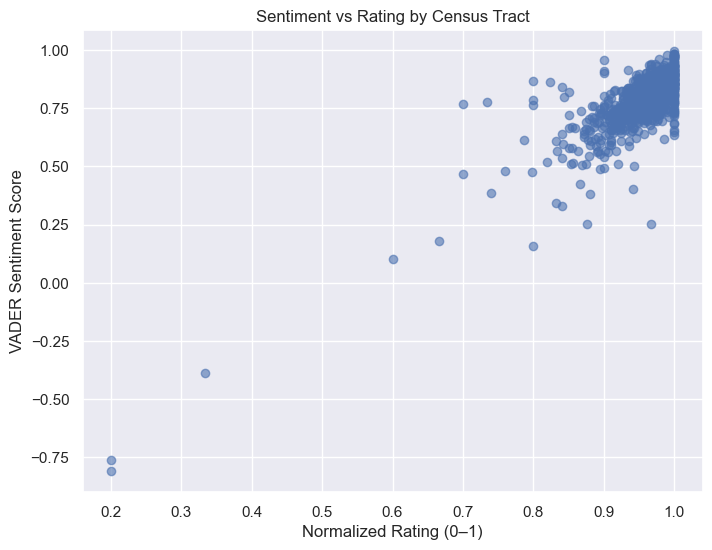

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(
    tract_level_summary["normalized_rating"],
    tract_level_summary["sentiment_score"],
    alpha=0.6,
)
plt.xlabel("Normalized Rating (0–1)")
plt.ylabel("VADER Sentiment Score")
plt.title("Sentiment vs Rating by Census Tract")
plt.grid(True)
plt.show()


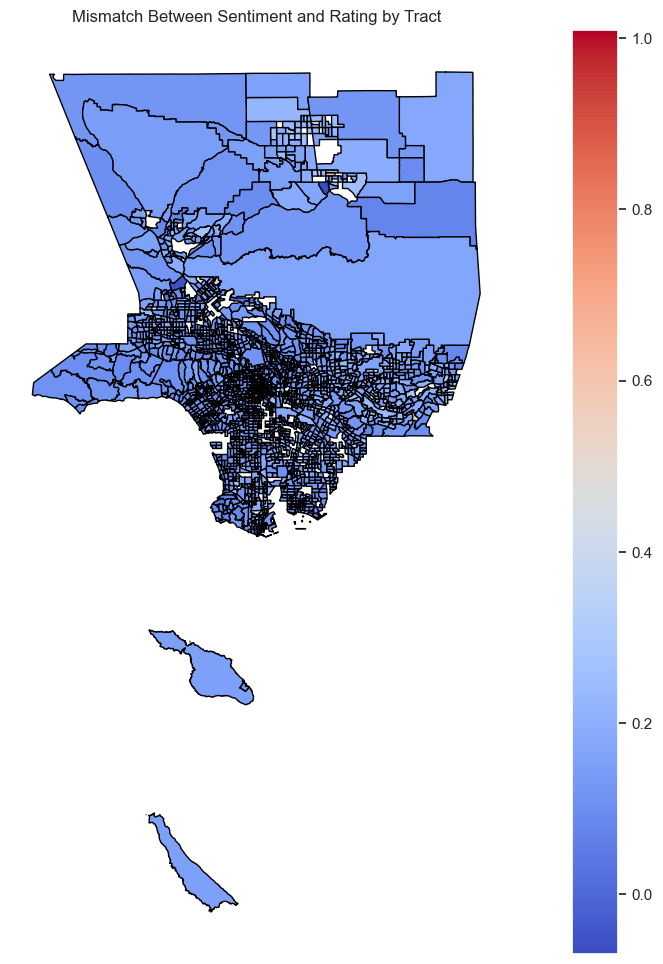

In [433]:
tract_gdf = tracts_gdf_2020.merge(tract_level_summary, on="GISJOIN", how="inner")
tract_gdf.plot(
    column="rating_sentiment_gap",
    cmap="coolwarm",
    legend=True,
    figsize=(18, 12),
    edgecolor="black",
)
plt.title("Mismatch Between Sentiment and Rating by Tract")
plt.axis("off")
plt.show()


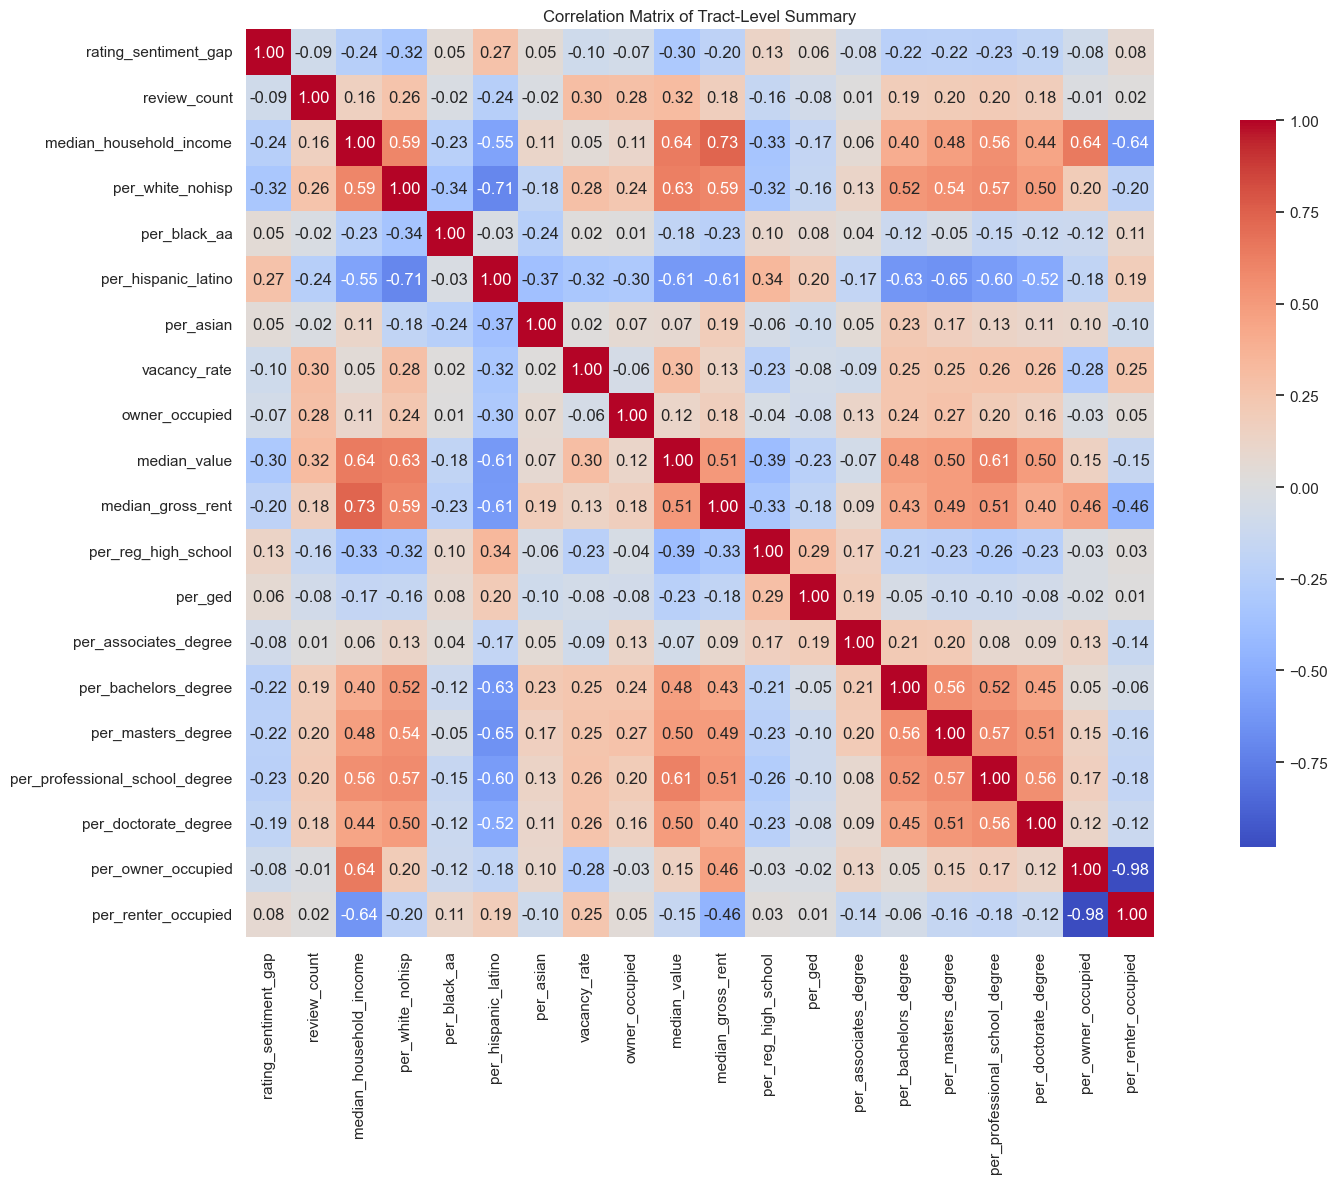

In [ ]:
numeric_cols = tract_level_summary.select_dtypes(include=[np.number]).columns.tolist()

numeric_cols = [
    col
    for col in numeric_cols
    if tract_level_summary[col].isnull().sum() < 0.5 * len(tract_level_summary)
]

numeric_cols.remove("sentiment_score")
numeric_cols.remove("normalized_rating")

corr_matrix = tract_level_summary[numeric_cols].corr()

plt.figure(figsize=(18, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Matrix of Tract-Level Summary")
plt.tight_layout()
plt.show()

In [ ]:
# find top 10 correlated features with rating_sentiment_gap
top_10_corr = corr_matrix["rating_sentiment_gap"].abs().nlargest(11).index[1:]
print("Top 10 correlated features with rating_sentiment_gap:")
print(corr_matrix["rating_sentiment_gap"][top_10_corr])

Top 10 correlated features with rating_sentiment_gap:
per_white_nohisp                 -0.316978
median_value                     -0.299697
per_hispanic_latino               0.268709
median_household_income          -0.242346
per_professional_school_degree   -0.227949
per_bachelors_degree             -0.224318
per_masters_degree               -0.217276
median_gross_rent                -0.200561
per_doctorate_degree             -0.190851
per_reg_high_school               0.130400
Name: rating_sentiment_gap, dtype: float64


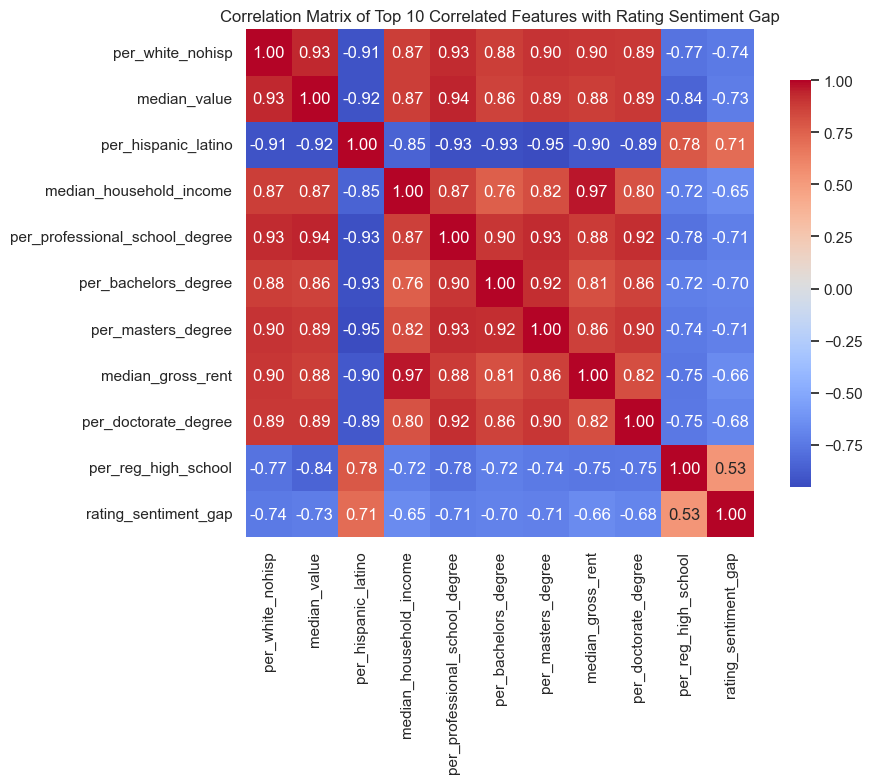

In [ ]:
top_10_corr_list = top_10_corr.tolist()
# add 'rating_sentiment_gap' to the list
top_10_corr_list.append("rating_sentiment_gap")

top_10_corr_features = corr_matrix[top_10_corr_list].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    top_10_corr_features,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Matrix of Top 10 Correlated Features with Rating Sentiment Gap")
plt.tight_layout()
plt.show()

In [ ]:
print("Top 10 correlated features with rating_sentiment_gap:")
print(top_10_corr_features["rating_sentiment_gap"].sort_values(ascending=False))

Top 10 correlated features with rating_sentiment_gap:
rating_sentiment_gap              1.000000
per_hispanic_latino               0.707921
per_reg_high_school               0.528280
median_household_income          -0.654102
median_gross_rent                -0.656518
per_doctorate_degree             -0.684335
per_bachelors_degree             -0.701169
per_masters_degree               -0.707746
per_professional_school_degree   -0.714438
median_value                     -0.729499
per_white_nohisp                 -0.739108
Name: rating_sentiment_gap, dtype: float64


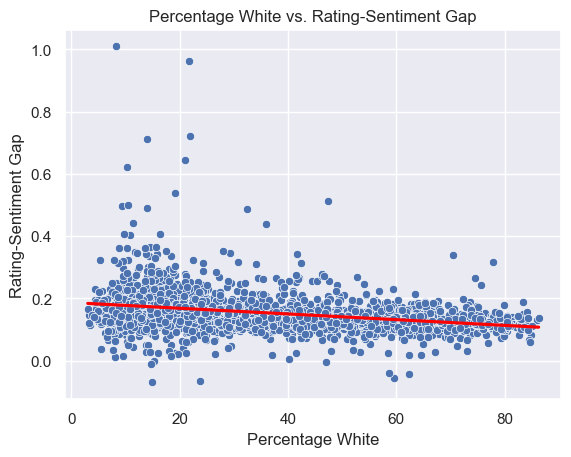

In [ ]:
sns.scatterplot(
    data=tract_level_summary, x="per_white_nohisp", y="rating_sentiment_gap"
)
sns.regplot(
    data=tract_level_summary,
    x="per_white_nohisp",
    y="rating_sentiment_gap",
    scatter=False,
    color="red",
)
plt.title("Percentage White vs. Rating-Sentiment Gap")
plt.xlabel("Percentage White")
plt.ylabel("Rating-Sentiment Gap")
plt.show()

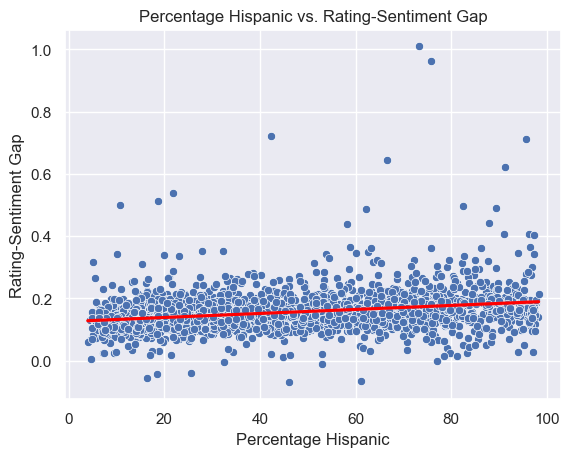

In [ ]:
sns.scatterplot(
    data=tract_level_summary, x="per_hispanic_latino", y="rating_sentiment_gap"
)
sns.regplot(
    data=tract_level_summary,
    x="per_hispanic_latino",
    y="rating_sentiment_gap",
    scatter=False,
    color="red",
)
plt.title("Percentage Hispanic vs. Rating-Sentiment Gap")
plt.xlabel("Percentage Hispanic")
plt.ylabel("Rating-Sentiment Gap")
plt.show()

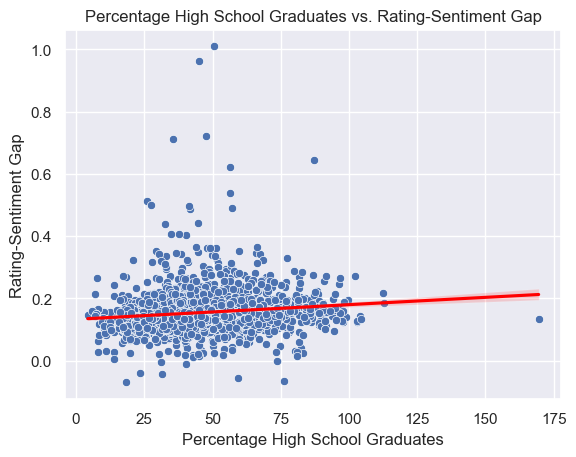

In [ ]:
sns.scatterplot(
    data=tract_level_summary, x="per_reg_high_school", y="rating_sentiment_gap"
)
sns.regplot(
    data=tract_level_summary,
    x="per_reg_high_school",
    y="rating_sentiment_gap",
    scatter=False,
    color="red",
)
plt.title("Percentage High School Graduates vs. Rating-Sentiment Gap")
plt.xlabel("Percentage High School Graduates")
plt.ylabel("Rating-Sentiment Gap")
plt.show()

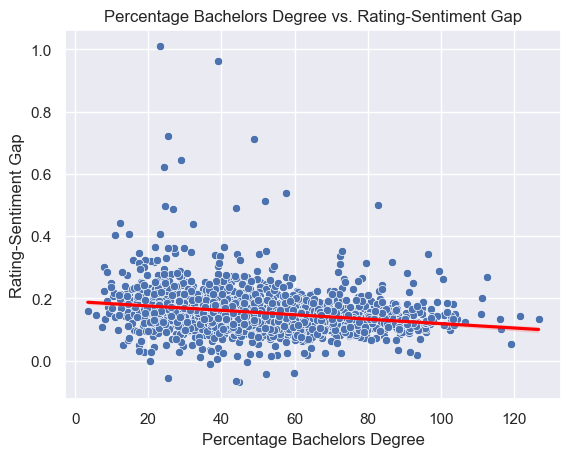

In [ ]:
sns.scatterplot(
    data=tract_level_summary, x="per_bachelors_degree", y="rating_sentiment_gap"
)
sns.regplot(
    data=tract_level_summary,
    x="per_bachelors_degree",
    y="rating_sentiment_gap",
    scatter=False,
    color="red",
)
plt.title("Percentage Bachelors Degree vs. Rating-Sentiment Gap")
plt.xlabel("Percentage Bachelors Degree")
plt.ylabel("Rating-Sentiment Gap")
plt.show()

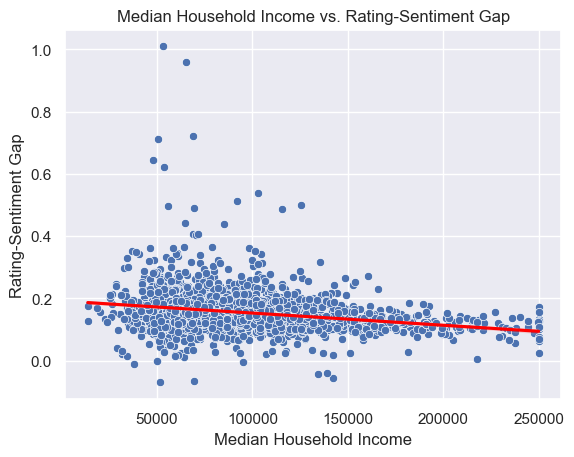

In [ ]:
sns.scatterplot(
    data=tract_level_summary, x="median_household_income", y="rating_sentiment_gap"
)
sns.regplot(
    data=tract_level_summary,
    x="median_household_income",
    y="rating_sentiment_gap",
    scatter=False,
    color="red",
)
plt.title("Median Household Income vs. Rating-Sentiment Gap")
plt.xlabel("Median Household Income")
plt.ylabel("Rating-Sentiment Gap")
plt.show()

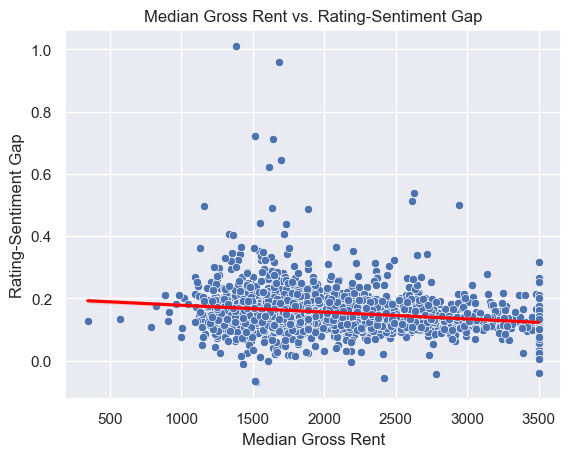

In [ ]:
sns.scatterplot(
    data=tract_level_summary, x="median_gross_rent", y="rating_sentiment_gap"
)
sns.regplot(
    data=tract_level_summary,
    x="median_gross_rent",
    y="rating_sentiment_gap",
    scatter=False,
    color="red",
)
plt.title("Median Gross Rent vs. Rating-Sentiment Gap")
plt.xlabel("Median Gross Rent")
plt.ylabel("Rating-Sentiment Gap")
plt.show()

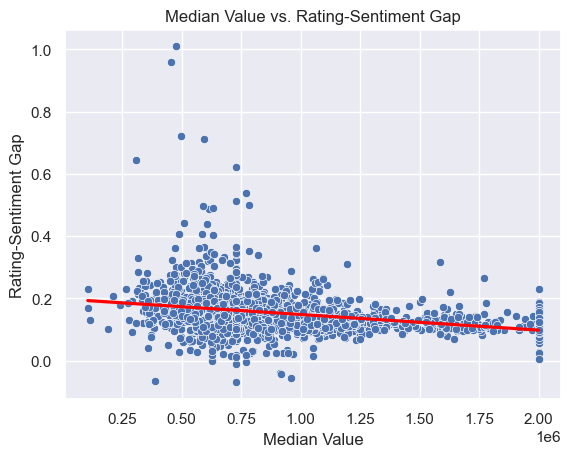

In [ ]:
sns.scatterplot(data=tract_level_summary, x="median_value", y="rating_sentiment_gap")
sns.regplot(
    data=tract_level_summary,
    x="median_value",
    y="rating_sentiment_gap",
    scatter=False,
    color="red",
)
plt.title("Median Value vs. Rating-Sentiment Gap")
plt.xlabel("Median Value")
plt.ylabel("Rating-Sentiment Gap")
plt.show()

In [673]:
print("Median Home Value: ")
print(filtered_la_df["median_value"].median())
print("Mean Home Value: ")
print(filtered_la_df["median_value"].mean())

Median Home Value: 
963800.0
Mean Home Value: 
1115201.5526060231


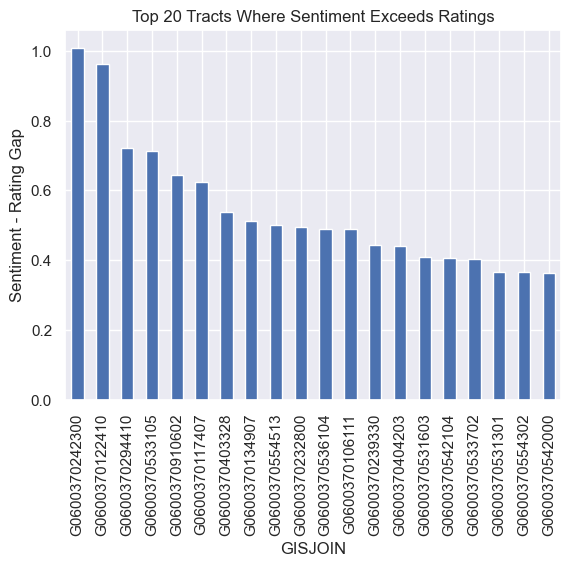

In [ ]:
tract_level_summary = tract_level_summary.copy()
top_divergent = tract_level_summary.sort_values(
    "rating_sentiment_gap", ascending=False
).head(20)

top_divergent.plot.bar(
    x="GISJOIN",
    y="rating_sentiment_gap",
    legend=False,
    title="Top 20 Tracts Where Sentiment Exceeds Ratings",
)
plt.ylabel("Sentiment - Rating Gap")
plt.show()

In [ ]:
top_divergent = top_divergent.merge(
    filtered_la_df[["GISJOIN", "neighbourhood_cleansed"]], on="GISJOIN", how="left"
)
top_divergent = top_divergent.drop_duplicates(subset=["GISJOIN"])
top_divergent = top_divergent[
    ["GISJOIN", "neighbourhood_cleansed", "rating_sentiment_gap"]
]
top_divergent = top_divergent.rename(
    columns={"neighbourhood_cleansed": "neighbourhood_airbnb"}
)
top_divergent = top_divergent.sort_values("rating_sentiment_gap", ascending=False)
top_divergent

,GISJOIN,neighbourhood_airbnb,rating_sentiment_gap
0,G0600370242300,Watts,1.009600
1,G0600370122410,Sun Valley,0.961200
2,G0600370294410,Harbor City,0.721033
5,G0600370533105,Huntington Park,0.713400
7,G0600370910602,Palmdale,0.643800
9,G0600370117407,North Hills,0.622400
12,G0600370403328,Diamond Bar,0.538850
16,G0600370134907,Canoga Park,0.512067
19,G0600370554513,Cerritos,0.499418
30,G0600370232800,South Park,0.495900


In [ ]:
filtered_la_df["neighbourhood_cleansed"].nunique()

264

In [ ]:
neighborhood_summary = (
    filtered_la_df.groupby(["neighbourhood_cleansed"])
    .agg(
        {
            "sentiment_score": "mean",
            "normalized_rating": "mean",
            "rating_sentiment_gap": "mean",
            "comments": "count",
        }
    )
    .reset_index()
    .rename(
        columns={
            "comments": "review_count",
            "neighbourhood_cleansed": "neighbourhood_airbnb",
        }
    )
)

neighborhood_summary


,neighbourhood_airbnb,sentiment_score,normalized_rating,rating_sentiment_gap,review_count
0,Acton,0.847494,0.984102,0.136607,236
1,Adams-Normandie,0.785097,0.968471,0.183374,208
2,Agoura Hills,0.853171,0.974734,0.121563,880
3,Agua Dulce,0.881637,0.983217,0.101580,235
4,Alhambra,0.782256,0.962626,0.180371,27452
...,...,...,...,...,...
259,Willowbrook,0.802184,0.961607,0.159423,1160
260,Wilmington,0.809714,0.974547,0.164833,625
261,Windsor Square,0.897510,0.987117,0.089607,913
262,Winnetka,0.806921,0.969945,0.163024,2814


In [ ]:
top_divergent_neighborhoods = top_divergent.merge(
    tract_level_summary,
    on="GISJOIN",
    how="left",
)

In [ ]:
top_divergent_neighborhoods.isnull().sum()
top_divergent_neighborhoods = top_divergent_neighborhoods.drop(
    columns=["rating_sentiment_gap_y"]
)
top_divergent_neighborhoods = top_divergent_neighborhoods.rename(
    columns={"rating_sentiment_gap_x": "rating_sentiment_gap"}
)

In [ ]:
print(
    top_divergent_neighborhoods[
        [
            "neighbourhood_airbnb",
            "per_white_nohisp",
            "per_hispanic_latino",
            "median_household_income",
            "median_value",
            "median_gross_rent",
            "review_count",
        ]
    ]
)

   neighbourhood_airbnb  per_white_nohisp  per_hispanic_latino  \
0                 Watts          8.289633            73.174667   
1            Sun Valley         21.757322            75.758368   
2           Harbor City         22.015066            42.372881   
3       Huntington Park         13.949649            95.583987   
4              Palmdale         20.934959            66.598916   
5           North Hills         10.367605            91.125790   
6           Diamond Bar         19.188005            21.748652   
7           Canoga Park         47.341686            18.760582   
8              Cerritos         10.393701            10.748031   
9            South Park          9.444720            82.498761   
10           South Gate         14.029561            89.314272   
11               Sylmar         32.509813            62.156546   
12             Florence         11.346089            87.915408   
13               Citrus         35.957938            58.220056   
14     Eas

#### Analysis and Modeling

In [ ]:
def categorize_sentiment(score):
    """Categorize sentiment score into Positive, Negative, or Neutral."""
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"


def rating_bucket(rating):
    """Categorize rating into High, Medium, or Low."""
    if rating >= 4.8:
        return "High"
    elif rating >= 4.0:
        return "Medium"
    else:
        return "Low"


def sentiment_rating_alignment(row):
    """Determine if sentiment and rating are aligned or misaligned."""
    if row["sentiment_category"] == "Negative" and row["rating_bucket"] == "High":
        return "Negative Sentiment, High Rating"
    elif row["sentiment_category"] == "Positive" and row["rating_bucket"] == "Low":
        return "Positive Sentiment, Low Rating"
    else:
        return "Aligned"


In [ ]:
filtered_la_df["sentiment_category"] = filtered_la_df["sentiment_score"].progress_apply(
    categorize_sentiment
)

100%|██████████| 1093619/1093619 [00:00<00:00, 2156554.82it/s]


In [669]:
filtered_la_df.shape

(1093582, 96)

In [ ]:
filtered_la_df["sentiment_category"].value_counts()

sentiment_category
Positive    1065315
Negative      15044
Neutral       13260
Name: count, dtype: int64

In [ ]:
filtered_la_df["rating_bucket"] = filtered_la_df["review_scores_rating"].apply(
    rating_bucket
)

In [ ]:
pd.crosstab(
    filtered_la_df["sentiment_category"],
    filtered_la_df["rating_bucket"],
    normalize="index",
)

rating_bucket,High,Low,Medium
sentiment_category,,,
Negative,0.366724,0.035429,0.597846
Neutral,0.599925,0.005882,0.394193
Positive,0.765166,0.001179,0.233655


In [ ]:
filtered_la_df["category_mismatch"] = filtered_la_df.apply(
    sentiment_rating_alignment, axis=1
)


In [481]:
filtered_la_df["category_mismatch"].value_counts()

category_mismatch
Aligned                            1086846
Negative Sentiment, High Rating       5517
Positive Sentiment, Low Rating        1256
Name: count, dtype: int64

In [ ]:
mismatch_df = filtered_la_df[
    filtered_la_df["category_mismatch"].isin(
        ["Negative Sentiment, High Rating", "Positive Sentiment, Low Rating"]
    )
].copy()

mismatch_df["comments_cleaned"] = mismatch_df["comments"].progress_apply(
    tfidf_clean_text
)

100%|██████████| 6773/6773 [00:24<00:00, 271.24it/s]


In [ ]:
mismatch_df[["comments_cleaned", "comments"]].sample(10)

,comments_cleaned,comments
815179,hoping beach least walking distance descriptio...,I was hoping that beaches are at least walking...
504498,leon photo look much better actual place tired...,Leon's photos look much better than the actual...
1187175,property nice view balcony everything looking ...,This property was very nice! The view from the...
930364,house feel like airbnb feel like house furnitu...,The house does not feel like an Airbnb. It fee...
1164157,holdens place great location close tourist pla...,Holdens place is at a great location close to ...
1114000,stay place hard find night unclear instruction...,Do not stay here. The place was hard to find d...
471394,david great nice house david quick respond tex...,David is great and he has a nice house. David ...
961344,everything fine problem showered little stem a...,Everything was just fine. The only problem was...
590874,stay loris mathews could better everything apa...,Our stay at Lori's and Mathew's could not have...
761814,unfortunately poor experience airbnb first bad...,"Unfortunately, we had a very poor experience a..."


In [ ]:
mismatch_df[mismatch_df["listing_id"] == 13776][
    ["comments", "sentiment_score", "review_scores_rating", "category_mismatch"]
].head(10)

,comments,sentiment_score,review_scores_rating,category_mismatch
770,DO NOT BOOK BECAUSE THEY HAVE NO CONSIDERATION...,-0.4466,4.84,"Negative Sentiment, High Rating"
779,"The Burnham Beach Bungalows are cozy, beach th...",-0.1270,4.84,"Negative Sentiment, High Rating"
812,"Wendy, unfortunately, made us quite uncomforta...",-0.9158,4.84,"Negative Sentiment, High Rating"


In [ ]:
# Consulted the SpaCy documentation next line of code
nlp = spacy.load("en_core_web_sm")


def remove_named_entities(text):
    """Remove named entities from the text."""
    doc = nlp(text)
    # Consulted the SpaCy documentation for the next line of code
    # The list comprehension was inspired by the SpaCy documentation
    # and W3Schools documentation
    tokens = [token.text for token in doc if not token.ent_type_ == "GPE"]
    return " ".join(tokens)


def extract_adjectives(text):
    """Extract adjectives from the text."""
    doc = nlp(text)
    # The use of "GPE" and "ADJ" is explained in the SpaCy documentation
    adjectives = [token.text for token in doc if token.pos_ == "ADJ"]
    return " ".join(adjectives)


mismatch_df["adjectives_only"] = mismatch_df["comments_cleaned"].progress_apply(
    extract_adjectives
)

100%|██████████| 6773/6773 [01:03<00:00, 106.42it/s]


In [ ]:
neg_text_high_rating = mismatch_df[
    mismatch_df["category_mismatch"] == "Negative Sentiment, High Rating"
]["adjectives_only"]
pos_text_low_rating = mismatch_df[
    mismatch_df["category_mismatch"] == "Positive Sentiment, Low Rating"
]["adjectives_only"]

all_docs = pd.concat([neg_text_high_rating, pos_text_low_rating], ignore_index=True)
labels = (["Negative Text, High Rating"] * len(neg_text_high_rating)) + (
    ["Positive Text, Low Rating"] * len(pos_text_low_rating)
)

# The next lines of code were inspired by the Scikit-learn documentation
vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, stop_words="english")
tfidf_matrix = vectorizer.fit_transform(all_docs)
feature_names = vectorizer.get_feature_names_out()

# ChatGPT suggested next line of code
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df["label"] = labels

# Consulted the NumPy documentation for the transpose function
grouped_tfidf = tfidf_df.groupby("label").mean().T

top_terms_neg = (
    grouped_tfidf["Negative Text, High Rating"].sort_values(ascending=False).head(20)
)
top_terms_pos = (
    grouped_tfidf["Positive Text, Low Rating"].sort_values(ascending=False).head(20)
)

print("Top Adjectives for Negative Text, High Rating:")
print(top_terms_neg)

print("\nTop Adjectives for Positive Text, Low Rating:")
print(top_terms_pos)


Top Adjectives for Negative Text, High Rating:
great            0.038932
nice             0.037948
clean            0.036160
good             0.034646
dirty            0.033022
bad              0.028646
small            0.025456
airbnb           0.024104
little           0.022628
uncomfortable    0.021421
quiet            0.020397
close            0.020235
hot              0.020170
difficult        0.018530
old              0.017734
comfortable      0.017225
overall          0.016688
private          0.014554
responsive       0.013582
second           0.013529
Name: Negative Text, High Rating, dtype: float64

Top Adjectives for Positive Text, Low Rating:
great          0.171632
good           0.082791
nice           0.070768
clean          0.063314
responsive     0.046673
comfortable    0.032336
perfect        0.030677
helpful        0.029859
amazing        0.025952
overall        0.022281
safe           0.022177
close          0.022093
easy           0.021867
friendly       0.021700
b

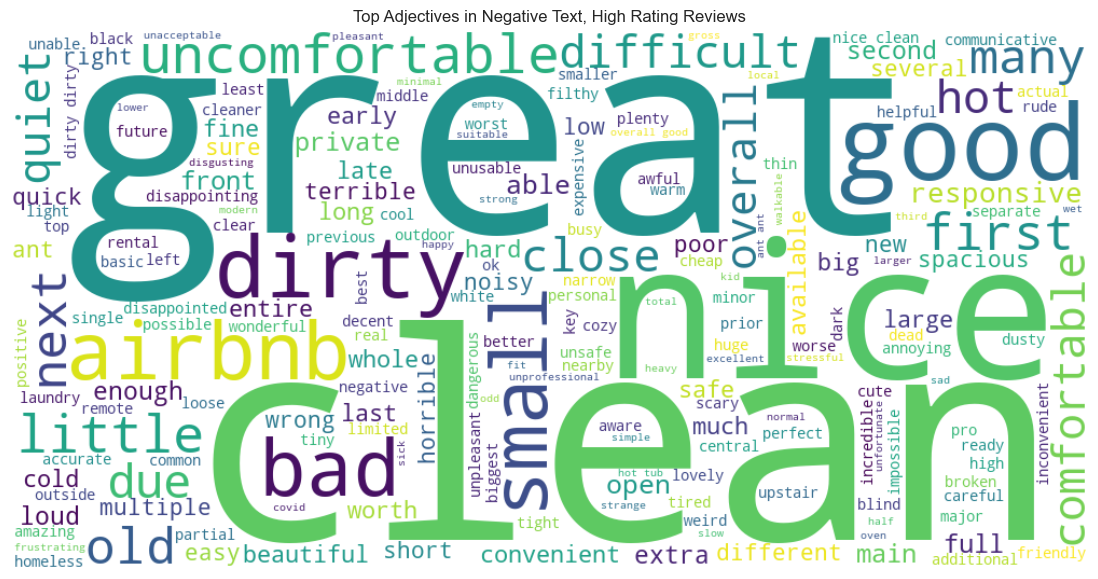

In [ ]:
negative_high_wordcloud = WordCloud(
    width=1000, height=500, background_color="white"
).generate(
    " ".join(
        mismatch_df[
            mismatch_df["category_mismatch"] == "Negative Sentiment, High Rating"
        ]["adjectives_only"]
    )
)
plt.figure(figsize=(15, 7))
plt.imshow(negative_high_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Top Adjectives in Negative Text, High Rating Reviews")
plt.show()

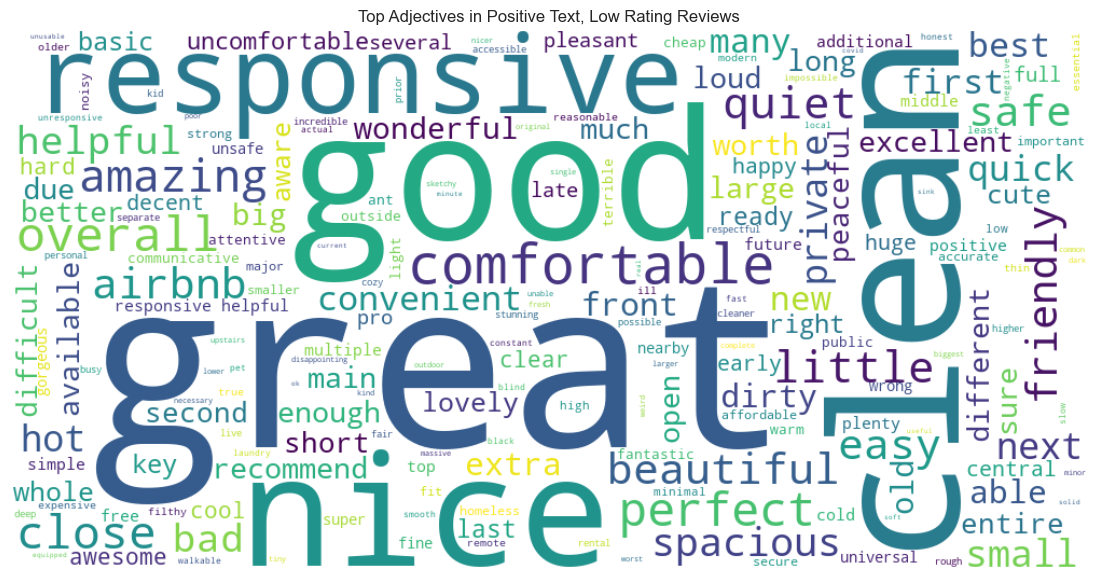

In [ ]:
positive_low_wordcloud = WordCloud(
    width=1000, height=500, background_color="white"
).generate(
    " ".join(
        mismatch_df[
            mismatch_df["category_mismatch"] == "Positive Sentiment, Low Rating"
        ]["adjectives_only"]
    )
)
plt.figure(figsize=(15, 7))
plt.imshow(positive_low_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Top Adjectives in Positive Text, Low Rating Reviews")
plt.show()

In [ ]:
filtered_la_df["tfidf_comments"] = filtered_la_df["comments"].progress_apply(
    tfidf_clean_text
)

100%|██████████| 1093619/1093619 [37:42<00:00, 483.42it/s]


In [ ]:
filtered_la_df.to_csv("data/airbnb/language_tfidf.csv", index=False)
filtered_la_df = pd.read_csv("data/airbnb/language_tfidf.csv", low_memory=False)

In [ ]:
def get_top_tfidf_phrases(text_series, top_n=20):
    """Extract top TF-IDF phrases from the text."""
    # The next lines of code were inspired by the Scikit-learn documentation
    vec = CountVectorizer(ngram_range=(2, 3), stop_words="english", max_features=5000)
    tfidf = make_pipeline(vec, TfidfTransformer())
    tfidf_matrix = tfidf.fit_transform(text_series)

    feature_names = vec.get_feature_names_out()
    # The next line of code was inspired by the Scikit-learn documentation
    tfidf_scores = tfidf_matrix.sum(axis=0).A1
    phrases_scores = list(zip(feature_names, tfidf_scores))
    sorted_scores = sorted(phrases_scores, key=lambda x: x[1], reverse=True)[:top_n]
    return sorted_scores


def has_adjective(phrase):
    """Check if the phrase contains an adjective."""
    doc = nlp(phrase)
    return any(token.pos_ == "ADJ" for token in doc if token.is_alpha)


def get_top_adjective_phrases(text_series, top_n=20):
    """Extract top phrases with adjectives from the text."""
    vec = CountVectorizer(ngram_range=(2, 3), stop_words="english", max_features=5000)
    # Next line of code was inspired by the Scikit-learn documentation and
    tfidf = make_pipeline(vec, TfidfTransformer())
    tfidf_matrix = tfidf.fit_transform(text_series)

    feature_names = vec.get_feature_names_out()
    tfidf_scores = tfidf_matrix.sum(axis=0).A1
    phrases_scores = list(zip(feature_names, tfidf_scores))
    # Lambda function is defined in the lambda documentation
    sorted_phrases = sorted(phrases_scores, key=lambda x: x[1], reverse=True)
    filtered = [
        (phrase, score) for phrase, score in sorted_phrases if has_adjective(phrase)
    ]

    return filtered[:top_n]


In [ ]:
neg_high_df = filtered_la_df[
    filtered_la_df["category_mismatch"] == "Negative Sentiment, High Rating"
]
pos_low_df = filtered_la_df[
    filtered_la_df["category_mismatch"] == "Positive Sentiment, Low Rating"
]

top_neg_high_adj = get_top_adjective_phrases(neg_high_df["tfidf_comments"])
top_pos_low_adj = get_top_adjective_phrases(pos_low_df["tfidf_comments"])


In [ ]:
filtered_la_df["GISJOIN"].nunique()

2228

In [ ]:
tract_mismatch_counts["GISJOIN"].nunique()

2228

In [ ]:
tract_mismatch_counts["pct_negative_text_high_rating"].value_counts()

pct_negative_text_high_rating
0.000000    653
0.017241     11
0.015873      9
0.012821      8
0.034483      8
           ... 
0.005663      1
0.003995      1
0.004073      1
0.004145      1
0.008039      1
Name: count, Length: 1099, dtype: int64

In [ ]:
def extract_adj_noun_phrases(text):
    doc = nlp(text)
    phrases = []
    for i in range(len(doc) - 1):
        if doc[i].pos_ == "ADJ" and doc[i + 1].pos_ == "NOUN":
            phrases.append(f"{doc[i].text} {doc[i + 1].text}")
    return phrases


neg_high_df = mismatch_df[
    mismatch_df["category_mismatch"] == "Negative Sentiment, High Rating"
]
pos_low_df = mismatch_df[
    mismatch_df["category_mismatch"] == "Positive Sentiment, Low Rating"
]


neg_high_phrases = neg_high_df["comments_cleaned"].progress_apply(
    extract_adj_noun_phrases
)
pos_low_phrases = pos_low_df["comments_cleaned"].progress_apply(
    extract_adj_noun_phrases
)

100%|██████████| 1256/1256 [00:09<00:00, 136.88it/s]


In [ ]:
neg_phrases_flat = [phrase for sublist in neg_high_phrases for phrase in sublist]
pos_phrases_flat = [phrase for sublist in pos_low_phrases for phrase in sublist]

neg_phrase_counts = Counter(neg_phrases_flat).most_common(20)
pos_phrase_counts = Counter(pos_phrases_flat).most_common(20)

neg_df = pd.DataFrame(neg_phrase_counts, columns=["Phrase", "Count"])
neg_df["Type"] = "Negative Text, High Rating"

pos_df = pd.DataFrame(pos_phrase_counts, columns=["Phrase", "Count"])
pos_df["Type"] = "Positive Text, Low Rating"

combined_df = pd.concat([neg_df, pos_df])

In [537]:
adj_noun_df = combined_df.copy()

In [ ]:
adj_noun_df = pd.concat([neg_df, pos_df])
adj_noun_df = adj_noun_df.sort_values(by="Count", ascending=False)

remove_phrases = [
    "next day",
    "first night",
    "multiple time",
    "next morning",
    "first time",
    "last minute",
    "early morning",
    "first day",
    "last night",
    "first night",
    "late night",
]

adj_noun_df_filtered = adj_noun_df[~adj_noun_df["Phrase"].isin(remove_phrases)]


In [546]:
adj_noun_df_filtered

,Phrase,Count,Type
0,hot water,139,"Negative Text, High Rating"
2,great location,106,"Negative Text, High Rating"
0,great location,87,"Positive Text, Low Rating"
4,front door,87,"Negative Text, High Rating"
5,nice place,85,"Negative Text, High Rating"
6,hot tub,77,"Negative Text, High Rating"
7,great place,74,"Negative Text, High Rating"
8,next door,71,"Negative Text, High Rating"
1,great place,68,"Positive Text, Low Rating"
9,good location,61,"Negative Text, High Rating"


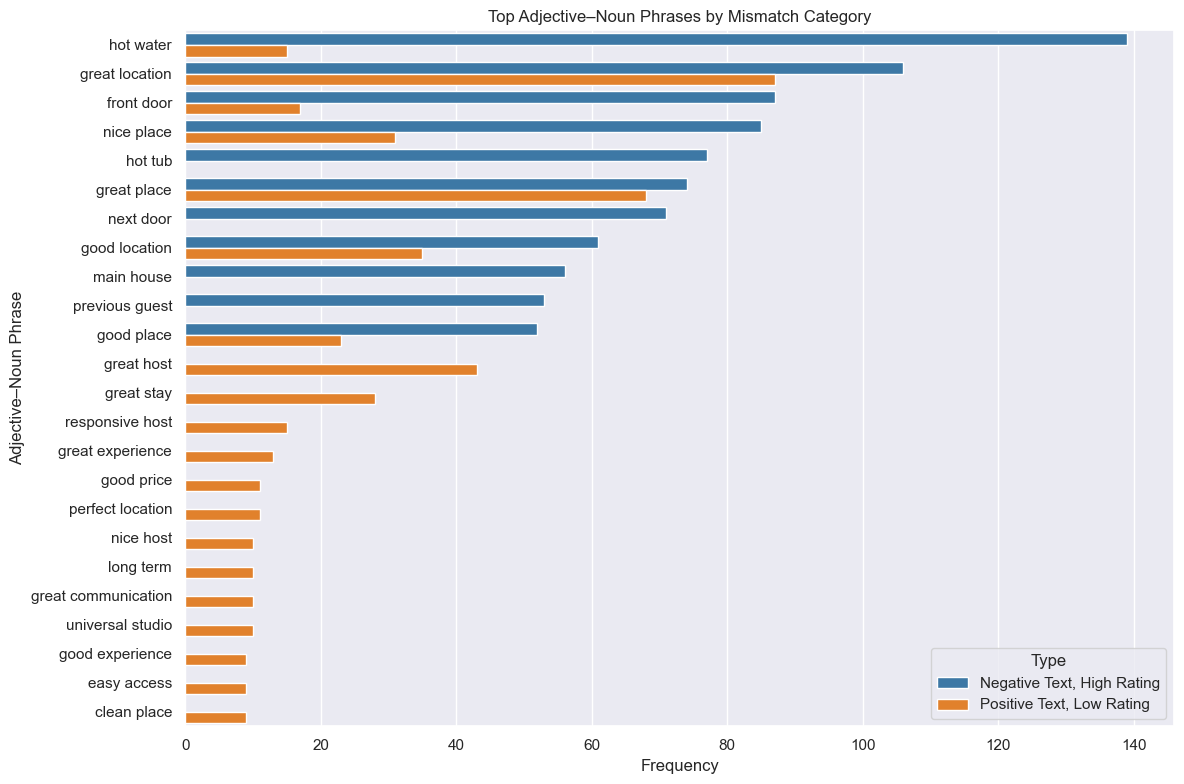

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=adj_noun_df_filtered,
    x="Count",
    y="Phrase",
    hue="Type",
    palette=["#2C7BB6", "#FF7F0E"],
)
plt.title("Top Adjective–Noun Phrases by Mismatch Category")
plt.xlabel("Frequency")
plt.ylabel("Adjective–Noun Phrase")
plt.tight_layout()
plt.show()

In [ ]:
mismatch_df["adj_noun_phrases"] = mismatch_df["comments_cleaned"].progress_apply(
    extract_adj_noun_phrases
)
exploded = mismatch_df.explode("adj_noun_phrases")

phrase_gisjoin_counts = (
    exploded.groupby(["GISJOIN"])
    .size()
    .reset_index(name="count")
    .rename(columns={"adj_noun_phrases": "Phrase"})
)

final_phrase_gisjoin_df = phrase_gisjoin_counts.merge(
    adj_noun_df_filtered[["Phrase", "Type"]], on="Phrase", how="left"
)


100%|██████████| 6773/6773 [00:41<00:00, 164.94it/s]


In [552]:
def extract_adj_following_word(text):
    """Extract adjective followed by the next word."""
    doc = nlp(text)
    phrases = []
    for i in range(len(doc) - 1):
        if doc[i].pos_ == "ADJ":
            next_token = doc[i + 1]
            if next_token.is_alpha:
                phrases.append(f"{doc[i].text} {next_token.text}")
    return phrases


In [ ]:
mismatch_df["adj_next_word_phrases"] = mismatch_df["comments_cleaned"].progress_apply(
    extract_adj_following_word
)

all_phrases = [
    phrase for sublist in mismatch_df["adj_next_word_phrases"] for phrase in sublist
]
phrase_counts = Counter(all_phrases).most_common(50)

adj_phrase_df = pd.DataFrame(phrase_counts, columns=["Phrase", "Count"])
print(adj_phrase_df)

100%|██████████| 6773/6773 [01:01<00:00, 110.97it/s]

                 Phrase  Count
0        great location    194
1             hot water    154
2           great place    142
3               hot tub    121
4            nice place    117
5           first night    116
6            front door    104
7              next day    100
8         good location     96
9             next door     79
10           great stay     76
11           good place     76
12           great host     73
13            first day     63
14          last minute     62
15           late night     60
16           main house     59
17           first time     56
18       previous guest     56
19        multiple time     54
20            good stay     53
21        early morning     51
22         next morning     50
23   quiet neighborhood     50
24           bad review     47
25          entire stay     46
26      responsive host     46
27         overall good     45
28  convenient location     45
29       bad experience     42
30       partial refund     40
31      

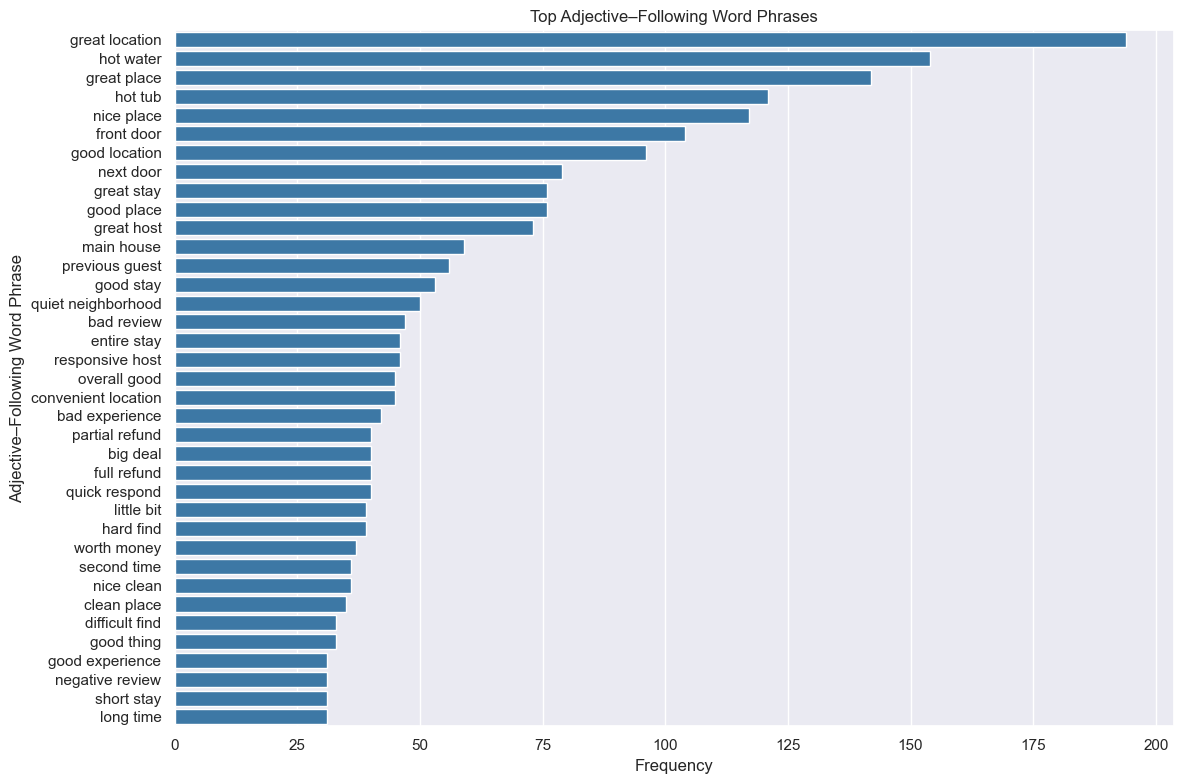

In [ ]:
remove_adj_phrases = [
    "first night",
    "first time",
    "last minute",
    "early morning",
    "first day",
    "last night",
    "first night",
    "late night",
    "next day",
    "next morning",
    "last day",
    "second night",
    "middle night",
]
adj_phrase_df = adj_phrase_df[~adj_phrase_df["Phrase"].isin(remove_adj_phrases)]
plt.figure(figsize=(12, 8))
sns.barplot(data=adj_phrase_df, x="Count", y="Phrase", color="#2C7BB6")
plt.title("Top Adjective–Following Word Phrases")
plt.xlabel("Frequency")
plt.ylabel("Adjective–Following Word Phrase")
plt.tight_layout()
plt.show()

In [ ]:
adj_phrase_df.sort_values(by="Count", ascending=False).reset_index(drop=True)

,Phrase,Count
0,great location,194
1,hot water,154
2,great place,142
3,hot tub,121
4,nice place,117
5,front door,104
6,good location,96
7,next door,79
8,good place,76
9,great stay,76


In [ ]:
top_divergent_neighborhoods

,GISJOIN,neighbourhood_airbnb,rating_sentiment_gap_x,sentiment_score,normalized_rating,rating_sentiment_gap_y,review_count,median_household_income,per_white_nohisp,per_black_aa,...,median_gross_rent,per_reg_high_school,per_ged,per_associates_degree,per_bachelors_degree,per_masters_degree,per_professional_school_degree,per_doctorate_degree,per_owner_occupied,per_renter_occupied
0,G0600370242300,Watts,1.009600,-0.809600,0.200000,1.009600,1,53062.0,8.289633,24.041952,...,1380.0,50.502513,10.552764,8.291457,23.115578,19.597990,3.517588,3.517588,27.215686,72.784314
1,G0600370122410,Sun Valley,0.961200,-0.761200,0.200000,0.961200,1,65060.0,21.757322,6.511506,...,1682.0,45.027624,13.812155,27.071823,38.950276,12.154696,5.248619,7.458564,13.000818,86.999182
2,G0600370294410,Harbor City,0.721033,-0.387700,0.333333,0.721033,3,69000.0,22.015066,21.996234,...,1518.0,47.634584,11.745514,13.866232,25.448613,15.171289,8.809135,3.425775,43.443627,56.556373
3,G0600370533105,Huntington Park,0.713400,0.253600,0.967000,0.713400,2,50658.0,13.949649,1.196863,...,1644.0,35.570470,8.053691,12.080537,48.993289,16.442953,4.697987,4.697987,11.196319,88.803681
4,G0600370910602,Palmdale,0.643800,0.156200,0.800000,0.643800,2,48143.0,20.934959,14.205059,...,1701.0,87.344913,13.399504,28.039702,29.032258,15.632754,2.977667,3.473945,40.843215,59.156785
5,G0600370117407,North Hills,0.622400,0.253600,0.876000,0.622400,3,53512.0,10.367605,2.642160,...,1615.0,56.573705,18.725100,15.936255,24.302789,5.577689,5.577689,5.577689,0.695825,99.304175
6,G0600370403328,Diamond Bar,0.538850,0.403150,0.942000,0.538850,4,102853.0,19.188005,2.055256,...,2629.0,56.521739,26.570048,29.227053,57.729469,29.227053,7.487923,8.695652,76.621859,23.378141
7,G0600370134907,Canoga Park,0.512067,0.327933,0.840000,0.512067,3,92020.0,47.341686,15.069421,...,2614.0,26.099426,7.934990,13.671128,52.007648,17.495220,7.361377,7.456979,0.000000,53.729942
8,G0600370554513,Cerritos,0.499418,0.380582,0.880000,0.499418,11,125417.0,10.393701,7.716535,...,2943.0,27.272727,9.090909,21.212121,82.828283,42.424242,24.747475,10.101010,76.231527,23.768473
9,G0600370232800,South Park,0.495900,0.104100,0.600000,0.495900,2,55625.0,9.444720,13.807635,...,1158.0,41.250000,11.250000,7.321429,24.464286,5.357143,2.500000,2.500000,26.810811,73.189189


In [ ]:
top_divergent_with_phrases = top_divergent_neighborhoods.merge(
    filtered_la_df[["GISJOIN", "tfidf_comments"]], on="GISJOIN", how="left"
)


In [ ]:
top_divergent_with_phrases["adj_next_word_phrases"] = top_divergent_with_phrases[
    "tfidf_comments"
].progress_apply(extract_adj_following_word)
top_divergent_with_phrases["adj_noun_phrases"] = top_divergent_with_phrases[
    "tfidf_comments"
].progress_apply(extract_adj_noun_phrases)

top_divergent_with_phrases["adj_next_word_phrases"].isnull().sum()

100%|██████████| 104/104 [00:00<00:00, 165.98it/s]


np.int64(0)

In [ ]:
unique_gisjoins = top_divergent_with_phrases["GISJOIN"].unique()[:20]

filtered_df = top_divergent_with_phrases[
    top_divergent_with_phrases["GISJOIN"].isin(unique_gisjoins)
]
records = []

for gisjoin, group in filtered_df.groupby("GISJOIN"):
    all_phrases = [
        phrase for sublist in group["adj_next_word_phrases"] for phrase in sublist
    ]

    phrase_counter = Counter(all_phrases)

    if phrase_counter:
        most_common_phrase, count = phrase_counter.most_common(1)[0]
        records.append(
            {"GISJOIN": gisjoin, "Phrase": most_common_phrase, "Count": count}
        )
    else:
        records.append({"GISJOIN": gisjoin, "Phrase": None, "Count": 0})

top_phrases_df = pd.DataFrame(records)

top_phrases_df


,GISJOIN,Phrase,Count
0,G0600370106111,vivian bruce,1
1,G0600370117407,good spot,1
2,G0600370122410,deep cleaning,1
3,G0600370134907,wonderful host,1
4,G0600370232800,old friend,1
5,G0600370239330,tight space,1
6,G0600370242300,disappointing frustrating,1
7,G0600370294410,false promise,1
8,G0600370403328,good one,1
9,G0600370404203,clean spacious,1


In [ ]:
unique_gisjoins = top_divergent_with_phrases["GISJOIN"].unique()[:20]

filtered_df = top_divergent_with_phrases[
    top_divergent_with_phrases["GISJOIN"].isin(unique_gisjoins)
]
records = []

for gisjoin, group in filtered_df.groupby("GISJOIN"):
    all_phrases = [
        phrase for sublist in group["adj_noun_phrases"] for phrase in sublist
    ]

    phrase_counter = Counter(all_phrases)

    neighborhood = group["neighbourhood_airbnb"].iloc[0]

    if phrase_counter:
        most_common_phrase, count = phrase_counter.most_common(1)[0]
        records.append(
            {
                "GISJOIN": gisjoin,
                "Neighborhood": neighborhood,
                "Phrase": most_common_phrase,
                "Count": count,
            }
        )
    else:
        records.append({"GISJOIN": gisjoin, "Phrase": None, "Count": 0})

top_adj_noun_phrases_df = pd.DataFrame(records)

top_adj_noun_phrases_df


,GISJOIN,Neighborhood,Phrase,Count
0,G0600370106111,Sylmar,smallest camper,1
1,G0600370117407,North Hills,good spot,1
2,G0600370122410,Sun Valley,deep cleaning,1
3,G0600370134907,Canoga Park,wonderful host,1
4,G0600370232800,South Park,old friend,1
5,G0600370239330,Florence,tight space,1
6,G0600370242300,Watts,unspecified amount,1
7,G0600370294410,Harbor City,false promise,1
8,G0600370403328,Diamond Bar,antiquated quality,1
9,G0600370404203,Citrus,spacious room,1


In [ ]:
unique_gisjoins = top_divergent_with_phrases["GISJOIN"].unique()[:20]
filtered_df = top_divergent_with_phrases[
    top_divergent_with_phrases["GISJOIN"].isin(unique_gisjoins)
]
records = []

top_n = 3

for gisjoin, group in filtered_df.groupby("GISJOIN"):
    all_phrases = [
        phrase for sublist in group["adj_next_word_phrases"] for phrase in sublist
    ]
    neighborhood = group["neighbourhood_airbnb"].iloc[0]

    phrase_counter = Counter(all_phrases)

    for phrase, count in phrase_counter.most_common(top_n):
        records.append(
            {
                "GISJOIN": gisjoin,
                "Neighborhood (Airbnb)": neighborhood,
                "Phrase": phrase,
                "Count": count,
            }
        )

top_phrases_df = pd.DataFrame(records)

top_phrases_df

,GISJOIN,Neighborhood (Airbnb),Phrase,Count
0,G0600370106111,Sylmar,vivian bruce,1
1,G0600370106111,Sylmar,smallest camper,1
2,G0600370106111,Sylmar,black mold,1
3,G0600370117407,North Hills,good spot,1
4,G0600370117407,North Hills,great neighborhood,1
5,G0600370117407,North Hills,beautiful place,1
6,G0600370122410,Sun Valley,deep cleaning,1
7,G0600370122410,Sun Valley,large cleaning,1
8,G0600370122410,Sun Valley,unable reach,1
9,G0600370134907,Canoga Park,wonderful host,1


### Topic Modeling

In [ ]:
def display_topics(model, feature_names, no_top_words=10):
    """Display the top words for each topic in the LDA model."""
    for idx, topic in enumerate(model.components_):
        # The argsort function is explained in the NumPy documentation
        top_features = [
            feature_names[i] for i in topic.argsort()[: -no_top_words - 1 : -1]
        ]
        print(f"Topic {idx + 1}: {', '.join(top_features)}")


vectorizer = CountVectorizer(stop_words="english", max_df=0.95, min_df=5)
X = vectorizer.fit_transform(mismatch_df["comments_cleaned"])

# Referred to the Scikit-learn documentation for LatentDirichletAllocation and Medium
# article for the LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

display_topics(lda, vectorizer.get_feature_names_out())

Topic 1: parking, place, house, stay, night, room, car, street, time, noise
Topic 2: bathroom, dirty, bed, room, house, shower, kitchen, towel, bedroom, place
Topic 3: place, stay, great, location, host, clean, good, nice, issue, responsive
Topic 4: host, day, stay, airbnb, night, time, didnt, check, issue, house
Topic 5: stay, place, home, host, parking, beach, bed, airbnb, location, house


### Final Outputs for Tableau

In [ ]:
tract_level_summary.to_csv("data/tableau_data/tract_level_summary.csv", index=False)
top_divergent_neighborhoods.to_csv(
    "data/tableau_data/top_divergent_neighborhoods.csv", index=False
)
phrase_gisjoin_counts.to_csv("data/tableau_data/phrase_gisjoin_counts.csv", index=False)
final_phrase_gisjoin_df.to_csv(
    "data/tableau_data/top_adj_noun_phrase_per_tract.csv", index=False
)
tract_mismatch_counts.to_csv("data/tableau_data/tract_mismatch_counts.csv", index=False)

#### References:

* https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html
* https://peps.python.org/pep-0008/#constants
* https://pypi.org/project/langdetect/ 
* https://docs.python.org/3/library/re.html 
* https://book.pythontips.com/en/latest/lambdas.html  
* https://vadersentiment.readthedocs.io/en/latest/pages/code_and_example.html 
* https://www.w3schools.com/python/ref_func_zip.asp 
* https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/ 
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html 
* https://www.geeksforgeeks.org/python-star-or-asterisk-operator/ 
* https://www.geeksforgeeks.org/matplotlib-pyplot-barh-function-in-python/ 
* https://spacy.io/usage/models 
* https://www.w3schools.com/python/python_lists_comprehension.asp 
* https://numpy.org/doc/2.2/reference/generated/numpy.ndarray.T.html 
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html 
* https://www.w3schools.com/python/ref_func_any.asp 
* https://medium.com/data-science/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0 
* https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html 
* https://numpy.org/doc/2.1/reference/generated/numpy.argsort.html
* https://www.ibm.com/think/topics/latent-dirichlet-allocation 

